In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import parselmouth
from parselmouth.praat import call
from scipy.stats import entropy, kurtosis, skew
import gc

# Define paths to your datasets
input_folders = [
    r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\2867216\26_29_09_2017_KCL\26-29_09_2017_KCL\ReadText\HC',
    r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\2867216\26_29_09_2017_KCL\26-29_09_2017_KCL\ReadText\PD'
]
labels = ['HC', 'PD']
csv_output_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\enhanced_integral_feature_data1.csv'
segment_duration = 5  # Duration of each segment in seconds

# Function for noise reduction using spectral gating
def spectral_gating(y, sr, threshold_ratio=1.5, noise_len=0.5):
    noise_samples = int(noise_len * sr)
    noise_profile = y[:noise_samples]
    noise_spectrum = np.mean(np.abs(librosa.stft(noise_profile)), axis=1)

    stft_y = librosa.stft(y)
    stft_y_magnitude, stft_y_phase = np.abs(stft_y), np.angle(stft_y)
    spectral_threshold = noise_spectrum * threshold_ratio
    stft_y_denoised = np.where(stft_y_magnitude < spectral_threshold[:, None], 0, stft_y_magnitude)
    y_denoised = librosa.istft(stft_y_denoised * np.exp(1j * stft_y_phase))
    return y_denoised

# Function to extract features using librosa
def extract_librosa_features(y, sr):
    features = {}
    
    # MFCC and its delta features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)  # First derivative
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)  # Second derivative
    
    # Store each MFCC coefficient and its delta as separate features
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}'] = mfcc[i].mean()
        features[f'mfcc_delta_{i+1}'] = mfcc_delta[i].mean()
        features[f'mfcc_delta2_{i+1}'] = mfcc_delta2[i].mean()
    
    # Extract other features
    features['mel_spectrogram'] = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128))
    features['chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rmse'] = np.mean(librosa.feature.rms(y=y))
    features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    features['spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
    
    return features

# Extract formants and other features from the voice sample using Praat
def extract_praat_features(file_path):
    sound = parselmouth.Sound(file_path)
    point_process = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    
    features = {
        'jitter_local': call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3),
        'shimmer_local': call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6),
        'f0_mean': call(sound.to_pitch(), "Get mean", 0, 0, "Hertz"),
        'hnr': call(sound.to_harmonicity(), "Get mean", 0, 0)
    }
    return features

# Function to extract statistical features
def extract_statistical_features(y):
    energy = np.abs(librosa.feature.rms(y=y))
    return {
        'entropy': entropy(energy.flatten()),
        'kurtosis': kurtosis(energy.flatten()),
        'skewness': skew(energy.flatten())
    }

# Function to extract all features from a .wav file
def extract_features(file_path, label, file_name):
    y, sr = librosa.load(file_path, sr=None)
    y = spectral_gating(y, sr)  # Apply noise reduction
    segment_samples = segment_duration * sr
    num_segments = len(y) // segment_samples
    all_features = []
    
    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        y_segment = y[start:end]
        
        # Extract all features
        librosa_features = extract_librosa_features(y_segment, sr)
        praat_features = extract_praat_features(file_path)
        statistical_features = extract_statistical_features(y_segment)
        
        # Combine all features into a single dictionary
        segment_features = {**librosa_features, **praat_features, **statistical_features}
        segment_features['label'] = label
        segment_features['file_name'] = file_name
        segment_features['segment'] = i + 1
        all_features.append(segment_features)
        
    return all_features

# Function to process all files in a folder and assign label (0 for HC, 1 for PD)
def process_folder(folder_path, label):
    folder_features = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            file_features = extract_features(file_path, label, file_name)
            folder_features.extend(file_features)
    return folder_features

# Extract features from both HC and PD folders
all_features = []
for folder, label in zip(input_folders, [0, 1]):
    folder_features = process_folder(folder, label)
    all_features.extend(folder_features)

# Save features to a CSV file
combined_features = pd.DataFrame(all_features)
combined_features.to_csv(csv_output_path, index=False)
print(f"Features extracted and saved to {csv_output_path}")


Features extracted and saved to F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\enhanced_integral_feature_data1.csv


In [3]:
import parselmouth
print("Praat Parselmouth version:", parselmouth.__version__)


Praat Parselmouth version: 0.4.4


In [3]:
import pandas as pd
import numpy as np

csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Print the column names
print(data.columns)


Index(['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2',
       'mfcc_delta2_2', 'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4',
       'mfcc_delta_4', 'mfcc_delta2_4', 'mfcc_5', 'mfcc_delta_5',
       'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 'mfcc_7',
       'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8',
       'mfcc_delta2_8', 'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10',
       'mfcc_delta_10', 'mfcc_delta2_10', 'mfcc_11', 'mfcc_delta_11',
       'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12',
       'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'mel_spectrogram',
       'chroma_stft', 'rmse', 'spectral_contrast', 'spectral_flatness',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr',
       'jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy',
       'kurtosis', 'skewness', 'label', 'file_name', 'segment'],
      dtype='object')


In [4]:
# Print the shape of the dataset
print(data.shape)

(1018, 58)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'max_depth': 76, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 253}
Training time (seconds): 118.6284441947937
Testing time (seconds): 0.03382134437561035
Accuracy: 0.9901960784313726
Precision: 0.9875
Recall: 0.9875
F1 Score: 0.9875
ROC AUC Score: 0.9991935483870968
Matthews Correlation Coefficient (MCC): 0.9794354838709678
Log-Loss: 0.18294909755451885
Cohen's Kappa: 0.9794354838709678
Mean Absolute Error (MAE): 0.00980392156862745
Specificity: 0.9919354838709677
Confusion Matrix:
 [[123   1]
 [  1  79]]
Optimized performance metrics saved to CSV.


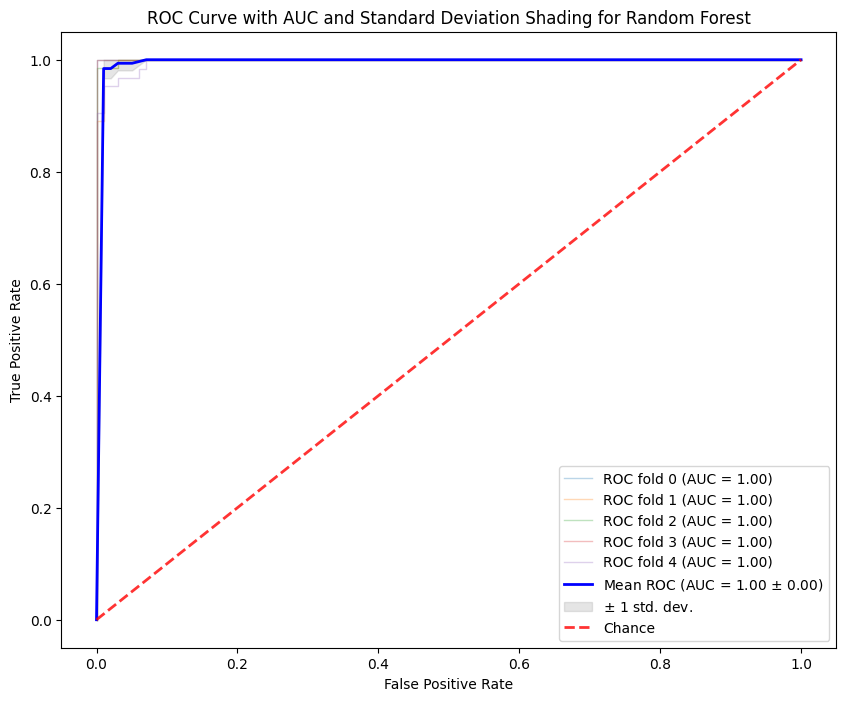

In [25]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error,
    roc_curve
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),  # Number of trees in the forest
    'max_depth': randint(10, 100),     # Maximum depth of the tree
    'min_samples_split': randint(2, 20), # Minimum samples needed to split a node
    'min_samples_leaf': randint(1, 20), # Minimum samples needed at a leaf node
    'max_features': ['sqrt', 'log2']  # Removed 'auto'
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for parameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=100,
    scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Time and train the model with parameter optimization
start_train = time.time()
random_search.fit(X_train, y_train)
end_train = time.time()

# Extract the best model
best_rf = random_search.best_estimator_

# Time the testing phase
start_test = time.time()
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
end_test = time.time()

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print the metrics
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train - start_train)
print("Testing time (seconds):", end_test - start_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Log-Loss:", log_loss_value)
print("Cohen's Kappa:", cohen_kappa)
print("Mean Absolute Error (MAE):", mae)
print("Specificity:", specificity)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Store the metrics in a DataFrame and save to a CSV for future reference
results = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'MCC', 
        'Log-Loss', "Cohen's Kappa", 'MAE', 'Specificity', 'Training Time', 'Testing Time'
    ],
    'Value': [
        accuracy, precision, recall, f1, roc_auc, mcc, log_loss_value,
        cohen_kappa, mae, specificity, end_train - start_train, end_test - start_test
    ]
})
results.to_csv(r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\model_optimized_performance_metricsrf.csv', index=False)
print("Optimized performance metrics saved to CSV.")

# Plot ROC curve with standard deviation shading using cross-validation
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    best_rf.fit(X_train.iloc[train], y_train.iloc[train])
    y_proba = best_rf.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test], y_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auc = roc_auc_score(y_train.iloc[test], y_proba)
    aucs.append(auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')

# Plot the mean ROC curve with standard deviation shading
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')

# Finalize the plot
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC and Standard Deviation Shading for Random Forest')
plt.legend(loc="lower right")
plt.savefig("rocmdvr_with_std.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()


In [15]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import uniform

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for SVC
param_dist = {
    'C': uniform(0.1, 10),           # Regularization parameter
    'kernel': ['linear'], # Kernel type
    'gamma': ['auto'],      # Kernel coefficient for 'rbf', 'poly'
    'degree': [2],             # Degree for 'poly' kernel
    'coef0': uniform(0, 1)           # Independent term in kernel function for 'poly'
}

# Initialize the classifier with probability enabled
svc = SVC(random_state=42, probability=True)

# Use RandomizedSearchCV for parameter tuning
random_search = RandomizedSearchCV(
    estimator=svc, param_distributions=param_dist, n_iter=100,
    scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Time and train the model with parameter optimization
start_train = time.time()
random_search.fit(X_train, y_train)
end_train = time.time()

# Extract the best model
best_svc = random_search.best_estimator_

# Time the testing phase
start_test = time.time()
y_pred = best_svc.predict(X_test)
y_pred_proba = best_svc.predict_proba(X_test)[:, 1]
end_test = time.time()

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print the metrics
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train - start_train)
print("Testing time (seconds):", end_test - start_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Log-Loss:", log_loss_value)
print("Cohen's Kappa:", cohen_kappa)
print("Mean Absolute Error (MAE):", mae)
print("Specificity:", specificity)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Store the metrics in a DataFrame and save to a CSV for future reference
results = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'MCC', 
        'Log-Loss', "Cohen's Kappa", 'MAE', 'Specificity', 'Training Time', 'Testing Time'
    ],
    'Value': [
        accuracy, precision, recall, f1, roc_auc, mcc, log_loss_value,
        cohen_kappa, mae, specificity, end_train - start_train, end_test - start_test
    ]
})
results.to_csv(r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\model_optimized_svc_performance_metrics.csv', index=False)

print("Optimized performance metrics saved to CSV.")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 61, 'min_samples_leaf': 7, 'min_samples_split': 12}
Training time (seconds): 5.455048561096191
Testing time (seconds): 0.0020003318786621094
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 2.220446049250313e-16
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
Optimized performance metrics saved to CSV.


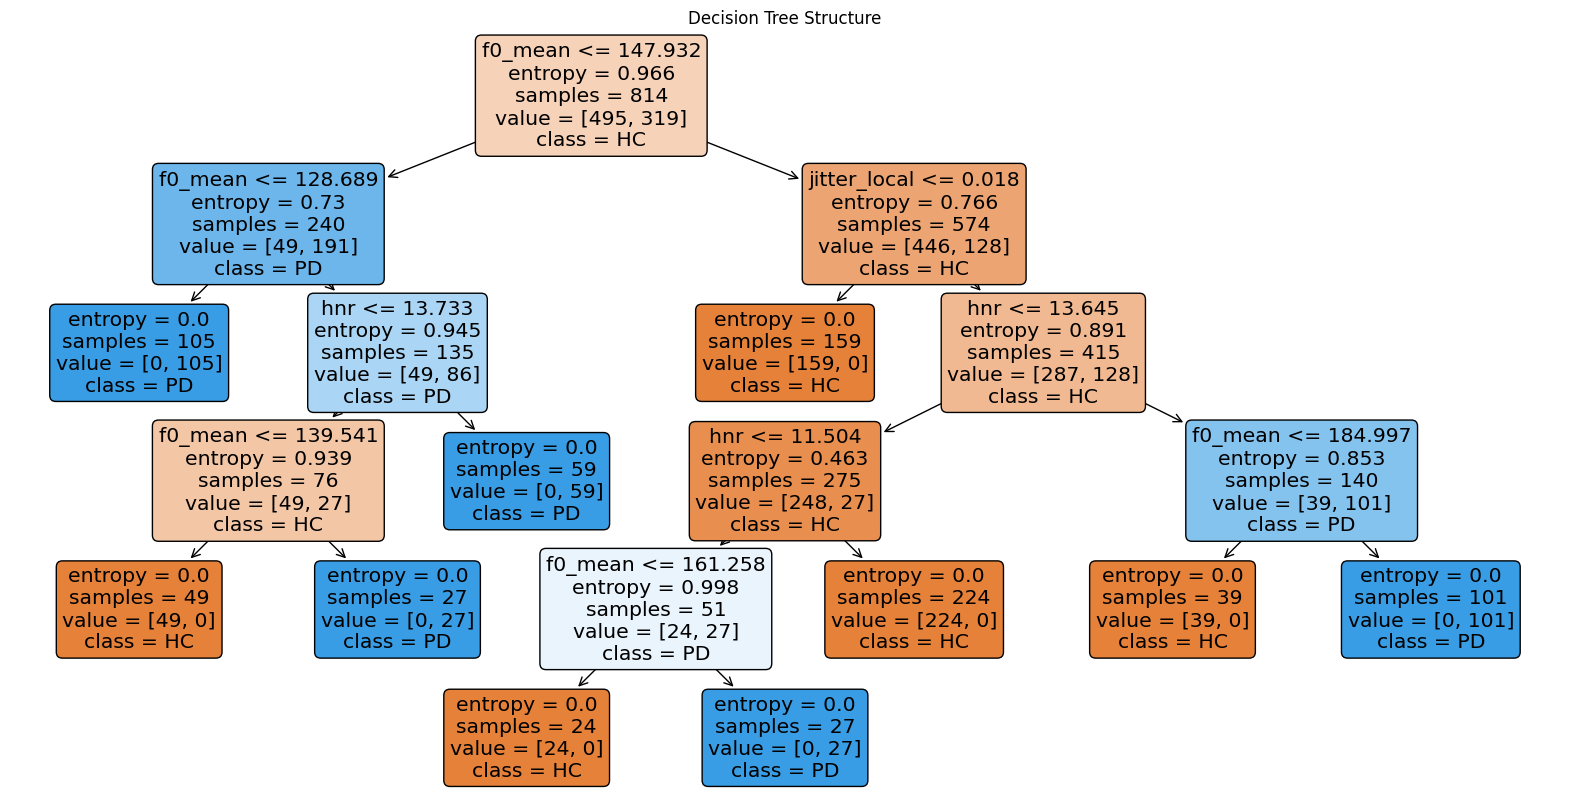

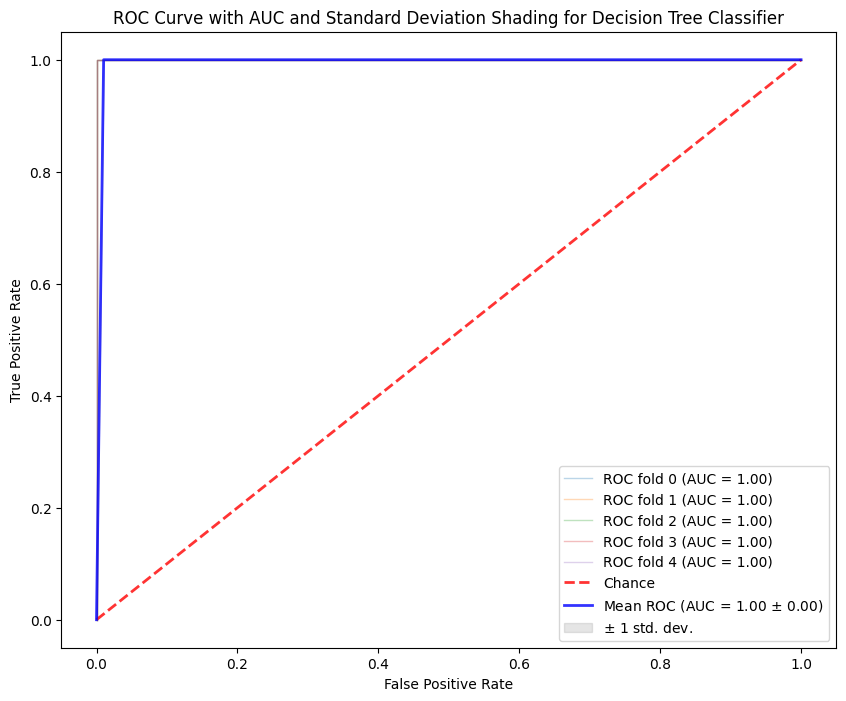

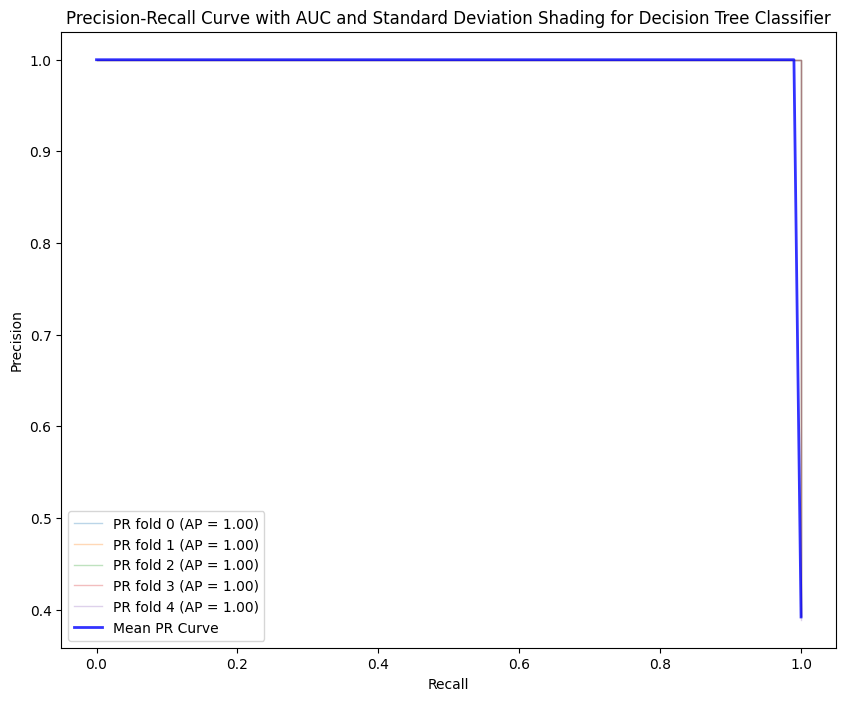

In [19]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error,
    RocCurveDisplay, PrecisionRecallDisplay
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for RandomizedSearchCV for Decision Tree
param_dist = {
    'max_depth': randint(1, 100),          # Maximum depth of the tree
    'min_samples_split': randint(2, 20),   # Minimum samples needed to split a node
    'min_samples_leaf': randint(1, 20),    # Minimum samples needed at a leaf node
    'criterion': ['gini', 'entropy']       # Criterion for split quality
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Use RandomizedSearchCV for parameter tuning
random_search = RandomizedSearchCV(
    estimator=dt, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Time and train the model with parameter optimization
start_train = time.time()
random_search.fit(X_train, y_train)
end_train = time.time()

# Extract the best model
best_dt = random_search.best_estimator_

# Time the testing phase
start_test = time.time()
y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]
end_test = time.time()

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print the metrics
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train - start_train)
print("Testing time (seconds):", end_test - start_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Log-Loss:", log_loss_value)
print("Cohen's Kappa:", cohen_kappa)
print("Mean Absolute Error (MAE):", mae)
print("Specificity:", specificity)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Store the metrics in a DataFrame and save to a CSV for future reference
results = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'MCC', 
        'Log-Loss', "Cohen's Kappa", 'MAE', 'Specificity', 'Training Time', 'Testing Time'
    ],
    'Value': [
        accuracy, precision, recall, f1, roc_auc, mcc, log_loss_value,
        cohen_kappa, mae, specificity, end_train - start_train, end_test - start_test
    ]
})
results.to_csv(r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\model_optimized_performance_metrics_dt.csv', index=False)

print("Optimized performance metrics saved to CSV.")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X.columns, class_names=['HC', 'PD'], filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.savefig(r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\decision_tree_structure.png')
plt.show()

# Plot ROC curve with standard deviation shading
cv = StratifiedKFold(n_splits=5)
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    best_dt.fit(X_train.iloc[train], y_train.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_dt, X_train.iloc[test], y_train.iloc[test],
        name=f"ROC fold {i}", alpha=0.3, lw=1, ax=plt.gca()
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC and Standard Deviation Shading for Decision Tree Classifier")
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
mean_precision = []
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    best_dt.fit(X_train.iloc[train], y_train.iloc[train])
    viz_pr = PrecisionRecallDisplay.from_estimator(
        best_dt, X_train.iloc[test], y_train.iloc[test],
        name=f"PR fold {i}", alpha=0.3, lw=1, ax=plt.gca()
    )
    mean_precision.append(np.interp(mean_fpr, viz_pr.recall[::-1], viz_pr.precision[::-1]))

# Calculate the mean and std precision-recall
mean_precision = np.mean(mean_precision, axis=0)
plt.plot(
    mean_fpr, mean_precision, color="b", label=r"Mean PR Curve", lw=2, alpha=0.8
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with AUC and Standard Deviation Shading for Decision Tree Classifier")
plt.legend(loc="lower left")
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
import random

# Load the dataset
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Get feature names
feature_names = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GA parameters
POP_SIZE = 50       # Population size
N_GEN = 40          # Number of generations
CX_PROB = 0.5       # Crossover probability
MUT_PROB = 0.2      # Mutation probability

# Define the individual and fitness function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(feature_names))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define fitness function
def evaluate(individual):
    # Select features based on the individual binary mask
    selected_features = [feature for feature, bit in zip(feature_names, individual) if bit == 1]
    
    # If no feature is selected, return a fitness score of 0
    if len(selected_features) == 0:
        return 0,
    
    # Create the training set with the selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Train a classifier (RandomForest)
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_train_selected, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test_selected)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy,

# Register operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Main Genetic Algorithm
def main():
    # Initialize population
    pop = toolbox.population(n=POP_SIZE)
    
    # Hall of Fame to store the best individuals
    hof = tools.HallOfFame(1)
    
    # Statistics to track progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # Run the genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB, ngen=N_GEN, 
                                   stats=stats, halloffame=hof, verbose=True)
    
    # Print the best individual
    best_individual = hof[0]
    print("Best individual is:", best_individual)
    
    # Get the selected features from the best individual
    selected_features = [feature for feature, bit in zip(feature_names, best_individual) if bit == 1]
    print("Selected features are:", selected_features)
    
    return selected_features

if __name__ == "__main__":
    selected_features = main()


gen	nevals	avg     	min     	max     
0  	50    	0.933725	0.789216	0.995098
1  	24    	0.964608	0.887255	0.995098
2  	26    	0.976569	0.946078	0.995098
3  	32    	0.98549 	0.960784	0.995098
4  	26    	0.992157	0.980392	1       
5  	31    	0.991667	0.955882	1       
6  	31    	0.994412	0.980392	1       
7  	28    	0.994118	0.980392	1       
8  	32    	0.994804	0.980392	1       
9  	23    	0.996373	0.985294	1       
10 	29    	0.995882	0.980392	1       
11 	28    	0.99451 	0.980392	1       
12 	26    	0.995196	0.965686	1       
13 	24    	0.996863	0.980392	1       
14 	27    	0.997059	0.931373	1       
15 	32    	0.997549	0.980392	1       
16 	26    	0.997451	0.97549 	1       
17 	32    	0.996569	0.955882	1       
18 	33    	0.998235	0.980392	1       
19 	32    	0.996471	0.97549 	1       
20 	35    	0.995588	0.95098 	1       
21 	35    	0.998137	0.97549 	1       
22 	37    	0.996373	0.97549 	1       
23 	22    	0.997059	0.97549 	1       
24 	25    	0.997353	0.97549 	1       
25 	35    	0

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from deap import base, creator, tools, algorithms
import random

# Load the dataset
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine train and test for t-SNE
combined_data = pd.concat([X_train, X_test])

# Apply t-SNE to the combined dataset
tsne = TSNE(n_components=2, random_state=42)
combined_reduced = tsne.fit_transform(combined_data)

# Split the reduced features back into train and test sets
X_train_reduced = combined_reduced[:len(X_train)]
X_test_reduced = combined_reduced[len(X_train):]

# Train a classifier on the reduced feature set
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_reduced)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after t-SNE feature reduction: {accuracy:.4f}")


Accuracy after t-SNE feature reduction: 0.6471


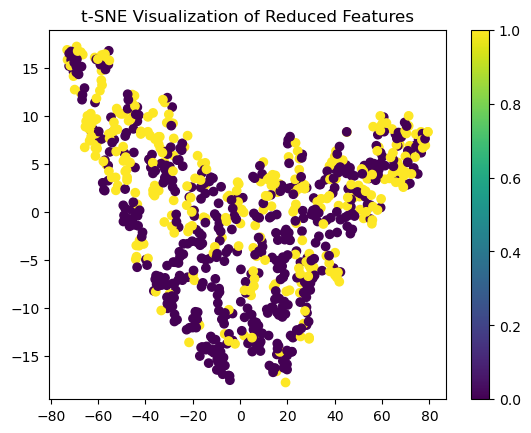

In [11]:
import matplotlib.pyplot as plt

# Visualize the t-SNE reduced features
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title("t-SNE Visualization of Reduced Features")
plt.show()


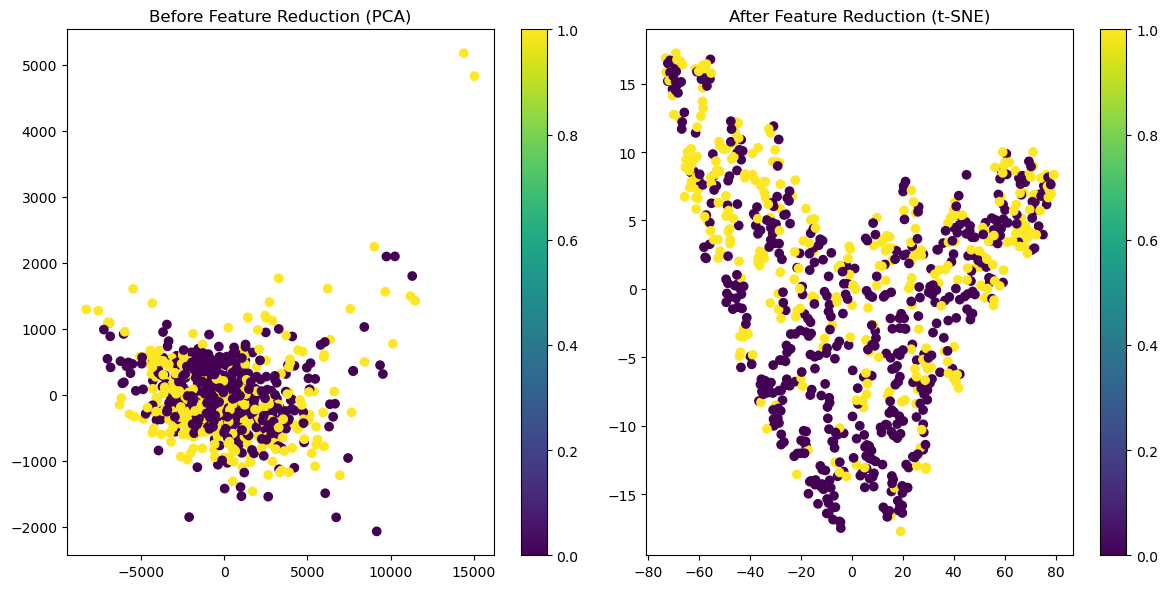

Accuracy after t-SNE feature reduction: 0.6471


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===================== PLOT BEFORE FEATURE REDUCTION ===================== #

# Use PCA to reduce the original high-dimensional features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA-reduced features before t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title("Before Feature Reduction (PCA)")
plt.colorbar()

# ===================== APPLY t-SNE FOR FEATURE REDUCTION ===================== #

# Combine train and test for t-SNE
combined_data = pd.concat([X_train, X_test])

# Apply t-SNE to the combined dataset
tsne = TSNE(n_components=2, random_state=42)
combined_reduced = tsne.fit_transform(combined_data)

# Split the reduced features back into train and test sets
X_train_reduced = combined_reduced[:len(X_train)]
X_test_reduced = combined_reduced[len(X_train):]

# ===================== PLOT AFTER FEATURE REDUCTION ===================== #

# Plot t-SNE-reduced features
plt.subplot(1, 2, 2)
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis')
plt.title("After Feature Reduction (t-SNE)")
plt.colorbar()

# Show the plots
plt.tight_layout()
plt.show()

# ===================== CLASSIFICATION WITH t-SNE REDUCED FEATURES ===================== #
# Train a classifier on the reduced feature set
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_reduced)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after t-SNE feature reduction: {accuracy:.4f}")


Accuracy: 0.9804
Feature Importances:
               Feature  Importance
50             f0_mean    0.190587
49       shimmer_local    0.099621
48        jitter_local    0.080505
51                 hnr    0.079915
40         chroma_stft    0.030765
41                rmse    0.030581
39     mel_spectrogram    0.027807
36             mfcc_13    0.026499
15              mfcc_6    0.025755
47                 zcr    0.025134
27             mfcc_10    0.024922
18              mfcc_7    0.021123
42   spectral_contrast    0.019591
0               mfcc_1    0.018583
6               mfcc_3    0.018298
9               mfcc_4    0.018295
12              mfcc_5    0.016525
30             mfcc_11    0.016369
46    spectral_rolloff    0.015450
21              mfcc_8    0.014994
45  spectral_bandwidth    0.013977
52             entropy    0.013457
44   spectral_centroid    0.013384
33             mfcc_12    0.010381
3               mfcc_2    0.010361
53            kurtosis    0.009062
24              m

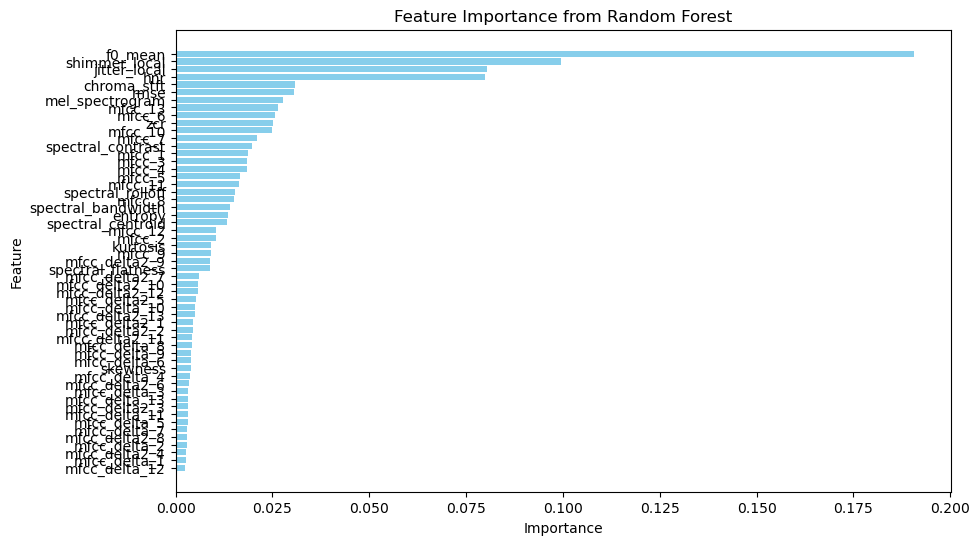

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Get feature names
feature_names = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get feature importances from the classifier
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features on top
plt.show()


Accuracy: 0.9804
Feature Importances:
               Feature  Importance
50             f0_mean    0.190587
49       shimmer_local    0.099621
48        jitter_local    0.080505
51                 hnr    0.079915
40         chroma_stft    0.030765
41                rmse    0.030581
39     mel_spectrogram    0.027807
36             mfcc_13    0.026499
15              mfcc_6    0.025755
47                 zcr    0.025134
27             mfcc_10    0.024922
18              mfcc_7    0.021123
42   spectral_contrast    0.019591
0               mfcc_1    0.018583
6               mfcc_3    0.018298
9               mfcc_4    0.018295
12              mfcc_5    0.016525
30             mfcc_11    0.016369
46    spectral_rolloff    0.015450
21              mfcc_8    0.014994
45  spectral_bandwidth    0.013977
52             entropy    0.013457
44   spectral_centroid    0.013384
33             mfcc_12    0.010381
3               mfcc_2    0.010361
53            kurtosis    0.009062
24              m

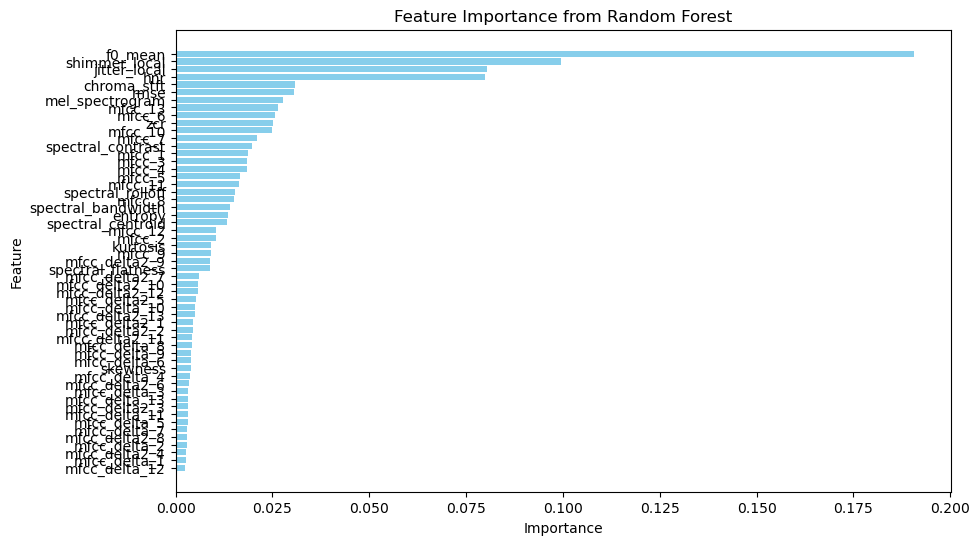

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Get feature names
feature_names = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get feature importances from the classifier
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features on top
plt.show()


In [3]:
import shap

# Initialize RandomForestClassifier and fit to training data
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot (global feature importance)
shap.summary_plot(shap_values[1], X_train, feature_names=X_train.columns)


ModuleNotFoundError: No module named 'shap'

               Feature  Mutual Information
50             f0_mean            0.671883
51                 hnr            0.671268
49       shimmer_local            0.671268
48        jitter_local            0.671268
40         chroma_stft            0.070479
47                 zcr            0.068733
27             mfcc_10            0.052616
21              mfcc_8            0.047814
20       mfcc_delta2_7            0.044864
43   spectral_flatness            0.040090
18              mfcc_7            0.039910
15              mfcc_6            0.031039
44   spectral_centroid            0.027995
33             mfcc_12            0.027336
2        mfcc_delta2_1            0.027227
42   spectral_contrast            0.025475
12              mfcc_5            0.025107
25        mfcc_delta_9            0.023461
0               mfcc_1            0.022203
8        mfcc_delta2_3            0.022198
23       mfcc_delta2_8            0.022027
3               mfcc_2            0.020110
6          

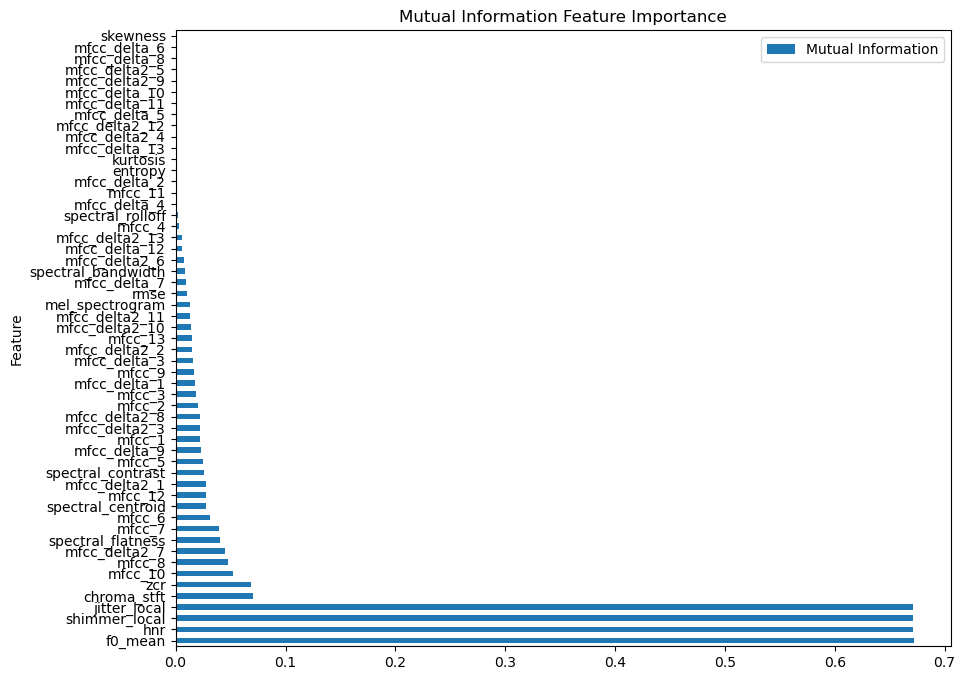

In [16]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Compute mutual information
mi = mutual_info_classif(X_train, y_train)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Print and plot mutual information
print(mi_df)
mi_df.plot(x='Feature', y='Mutual Information', kind='barh', figsize=(10, 8))
plt.title('Mutual Information Feature Importance')
plt.show()


In [1]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Boruta Feature Selection
boruta_selector = BorutaPy(clf, n_estimators='auto', random_state=42)
boruta_selector.fit(X_train.values, y_train)

# Get selected features
selected_features = X.columns[boruta_selector.support_].tolist()
print("Selected features by Boruta:", selected_features)


ModuleNotFoundError: No module named 'boruta'

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Training time (seconds): 4.232939720153809
Testing time (seconds): 0.017052173614501953
Accuracy: 0.7450980392156863
Precision: 0.7
Recall: 0.6125
F1 Score: 0.6533333333333333
ROC AUC Score: 0.7215725806451614
Matthews Correlation Coefficient (MCC): 0.45572245521458327
Log-Loss: 9.187597922716137
Cohen's Kappa: 0.45319587628865976
Mean Absolute Error (MAE): 0.2549019607843137
Specificity: 0.8306451612903226
Confusion Matrix:
 [[103  21]
 [ 31  49]]


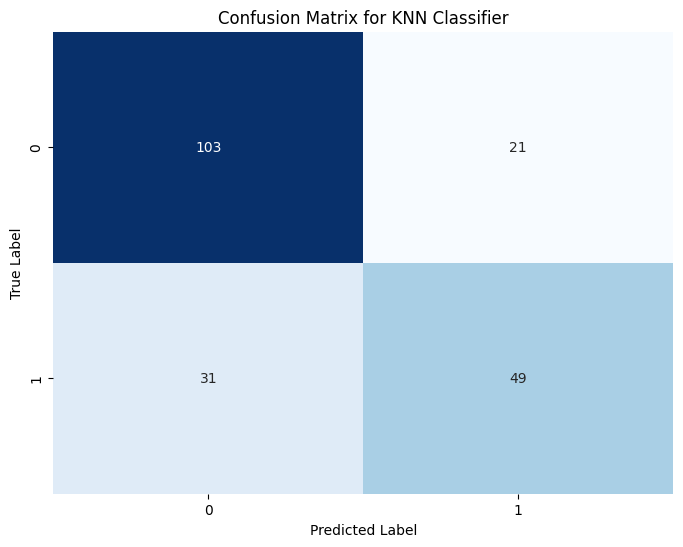

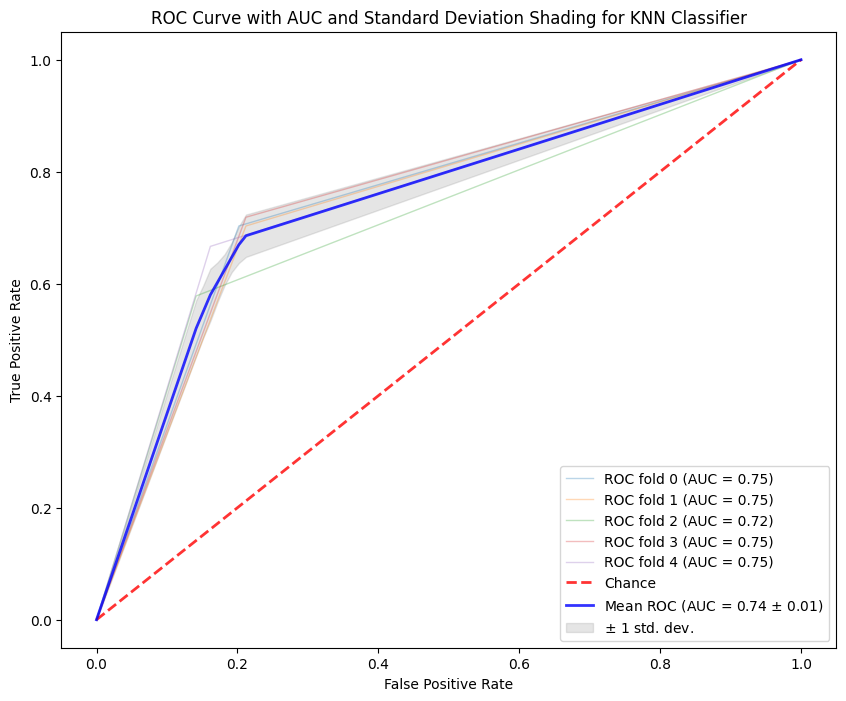

Optimized performance metrics saved to CSV.


In [16]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error,
    RocCurveDisplay
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for RandomizedSearchCV for KNN
param_dist = {
    'n_neighbors': randint(1, 30),      # Number of neighbors to use
    'weights': ['uniform', 'distance'], # Weight function
    'p': [1, 2]                         # Power parameter for the Minkowski metric
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Use RandomizedSearchCV for parameter tuning
random_search = RandomizedSearchCV(
    estimator=knn, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Time and train the model with parameter optimization
start_train = time.time()
random_search.fit(X_train, y_train)
end_train = time.time()

# Extract the best model
best_knn = random_search.best_estimator_

# Time the testing phase
start_test = time.time()
y_pred = best_knn.predict(X_test)
y_pred_proba = best_knn.predict_proba(X_test)[:, 1]
end_test = time.time()

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print the metrics
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train - start_train)
print("Testing time (seconds):", end_test - start_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Log-Loss:", log_loss_value)
print("Cohen's Kappa:", cohen_kappa)
print("Mean Absolute Error (MAE):", mae)
print("Specificity:", specificity)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC curve with std shading
cv = StratifiedKFold(n_splits=5)
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    best_knn.fit(X_train.iloc[train], y_train.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_knn, X_train.iloc[test], y_train.iloc[test],
        name=f"ROC fold {i}", alpha=0.3, lw=1, ax=plt.gca()
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC and Standard Deviation Shading for KNN Classifier")
plt.legend(loc="lower right")
plt.show()

# Optional: Store the metrics in a DataFrame and save to a CSV for future reference
results = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'MCC', 
        'Log-Loss', "Cohen's Kappa", 'MAE', 'Specificity', 'Training Time', 'Testing Time'
    ],
    'Value': [
        accuracy, precision, recall, f1, roc_auc, mcc, log_loss_value,
        cohen_kappa, mae, specificity, end_train - start_train, end_test - start_test
    ]
})
results.to_csv(r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\model_knn_performance_metrics.csv', index=False)

print("Optimized performance metrics saved to CSV.")


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error,
    roc_curve
)
from scipy.stats import uniform

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for RandomizedSearchCV for SVM
param_dist = {
    'C': uniform(0.1, 10),            # Regularization parameter
    'gamma': uniform(0.01, 0.3),      # Kernel coefficient for 'rbf'
    'kernel': ['linear']                 # Use RBF kernel for non-linear SVM
}

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=42)

# Use RandomizedSearchCV for parameter tuning
random_search = RandomizedSearchCV(
    estimator=svm, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Time and train the model with parameter optimization
start_train = time.time()
random_search.fit(X_train, y_train)
end_train = time.time()

# Extract the best model
best_svm = random_search.best_estimator_

# Time the testing phase
start_test = time.time()
y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.predict_proba(X_test)[:, 1]
end_test = time.time()

# Evaluate the optimized model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print the metrics
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train - start_train)
print("Testing time (seconds):", end_test - start_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Log-Loss:", log_loss_value)
print("Cohen's Kappa:", cohen_kappa)
print("Mean Absolute Error (MAE):", mae)
print("Specificity:", specificity)
print("Confusion Matrix:\n", conf_matrix)

# Plot ROC curve with standard deviation shading using cross-validation
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    best_svm.fit(X_train.iloc[train], y_train.iloc[train])
    y_proba = best_svm.predict_proba(X_train.iloc[test])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test], y_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auc = roc_auc_score(y_train.iloc[test], y_proba)
    aucs.append(auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')

# Plot the mean ROC curve with standard deviation shading
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')

# Finalize the plot
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC and Standard Deviation Shading for SVM Classifier')
plt.legend(loc="lower right")
plt.savefig("rocmdvr_svm_with_std.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()


Fitting 5 folds for each of 50 candidates, totalling 250 fits


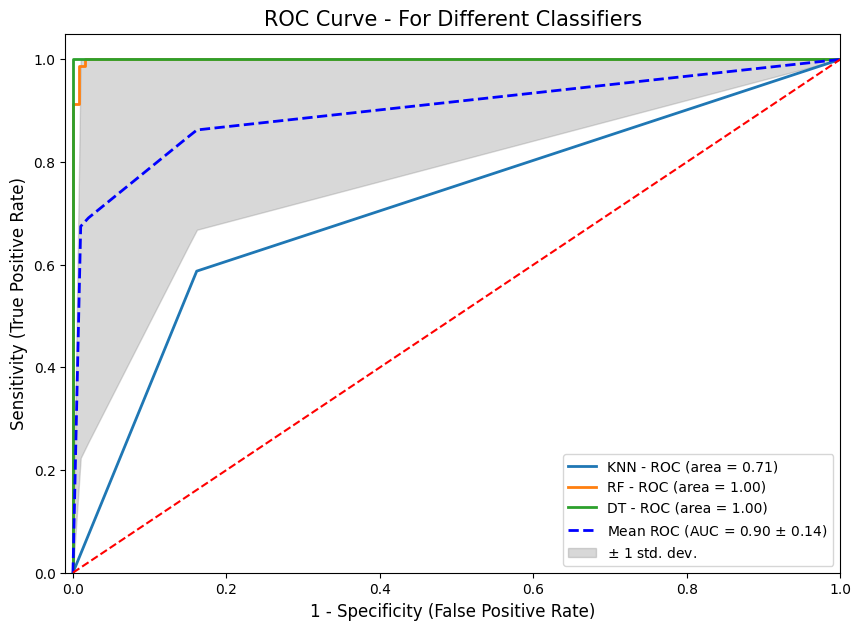

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

# Assume models have already been trained and saved as best_knn, best_rf, best_dt
models = [
    {'label': 'KNN', 'model': best_knn},
    {'label': 'RF', 'model': best_rf},
    {'label': 'DT', 'model': best_dt}
]

# Prepare for mean and standard deviation calculation
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Plot individual ROC curves for each model
plt.figure(figsize=(10, 7))
for m in models:
    model = m['model']
    
    # Assuming model has predict_proba
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Interpolating TPR
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auc = roc_auc_score(y_test, y_pred_proba)
    aucs.append(auc)
    
    # Plotting ROC curve for each model
    plt.plot(fpr, tpr, lw=2, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

# Plot mean ROC curve and shaded std deviation
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)

std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3,
                 label=r'$\pm$ 1 std. dev.')

# Final plot adjustments
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC Curve - For Different Classifiers', fontsize=15)
plt.legend(loc="lower right", fontsize=10)
plt.savefig("rocmdvr.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()


In [2]:
# Loading the dataset to print the feature names
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'

# Load the data
data = pd.read_csv(csv_output_path)

# Print the feature names (columns)
feature_names = data.columns.tolist()
print("Feature Names:", feature_names)


Feature Names: ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'mel_spectrogram', 'chroma_stft', 'rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness', 'label', 'file_name', 'segment']


In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Define the labels
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize and train the classifier
    clf = RandomForestClassifier(random_state=42)
    start_train = time.time()
    clf.fit(X_train, y_train)
    end_train = time.time()
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=42)
start_train_all = time.time()
clf.fit(X_train_all, y_train_all)
end_train_all = time.time()

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = clf.predict(X_test_all)
y_pred_proba_all = clf.predict_proba(X_test_all)[:, 1]
end_test_all = time.time()

accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all)
recall_all = recall_score(y_test_all, y_pred_all)
f1_all = f1_score(y_test_all, y_pred_all)
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results.csv', index=False)



Feature Set: MFCC
Training time (seconds): 2.626156806945801
Testing time (seconds): 0.05651092529296875
Accuracy: 0.8333333333333334
Precision: 0.896551724137931
Recall: 0.65
F1 Score: 0.7536231884057972
ROC AUC Score: 0.9269657258064516
Matthews Correlation Coefficient (MCC): 0.6511522622196125
Log-Loss: 0.44339771718126386
Cohen's Kappa: 0.6324713861805851
Mean Absolute Error (MAE): 0.16666666666666666
Specificity: 0.9516129032258065
Confusion Matrix:
 [[118   6]
 [ 28  52]]

Feature Set: Spectrogram
Training time (seconds): 1.2352502346038818
Testing time (seconds): 0.05336141586303711
Accuracy: 0.7745098039215687
Precision: 0.7236842105263158
Recall: 0.6875
F1 Score: 0.7051282051282051
ROC AUC Score: 0.8307459677419355
Matthews Correlation Coefficient (MCC): 0.5232334518853907
Log-Loss: 0.49818362942287203
Cohen's Kappa: 0.5227827502034175
Mean Absolute Error (MAE): 0.22549019607843138
Specificity: 0.8306451612903226
Confusion Matrix:
 [[103  21]
 [ 25  55]]

Feature Set: Spectra

In [15]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint


# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']
# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier
    clf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)[:, 1]
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all)
recall_all = recall_score(y_test_all, y_pred_all)
f1_all = f1_score(y_test_all, y_pred_all)
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: MFCC
Best Parameters: {'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 58}
Training time (seconds): 172.23588275909424
Testing time (seconds): 0.055573463439941406
Accuracy: 0.8186274509803921
Precision: 0.8524590163934426
Recall: 0.65
F1 Score: 0.7375886524822695
ROC AUC Score: 0.938508064516129
Matthews Correlation Coefficient (MCC): 0.6157639181182766
Log-Loss: 0.4372444088074161
Cohen's Kappa: 0.6028204588507682
Mean Absolute Error (MAE): 0.18137254901960784
Specificity: 0.9274193548387096
Confusion Matrix:
 [[115   9]
 [ 28  52]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: Spectrogram
Best Parameters: {'max_depth': 95, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 276}
Training time (seconds): 95.30683994293213
Testing time (seconds): 0.16302824020385742
Accuracy: 0.7745098039215

In [16]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.818627   0.852459  0.6500  0.737589  0.938508  0.615764   
1    Spectrogram  0.774510   0.729730  0.6750  0.701299  0.843649  0.521658   
2       Spectral  0.813725   0.828125  0.6625  0.736111  0.888911  0.603747   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   
4   All Combined  0.985294   0.975309  0.9875  0.981366  0.999294  0.969272   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  Testing Time  
0  0.437244       0.602820  0.181373     0.927419     172.235883      0.055573  
1  0.475723       0.520638  0.225490     0.838710      95.306840      0.163028  
2  0.447684       0.594900  0.186275     0.911290      91.219062      0.055510  
3  0.037082       1.000000  0.000000     1.000000      66.146405      0.074512  
4  0.178727       0.969221  0.014706     0.983871     166.451058      0.089153

Fitting 5 folds for each of 50 candidates, totalling 250 fits


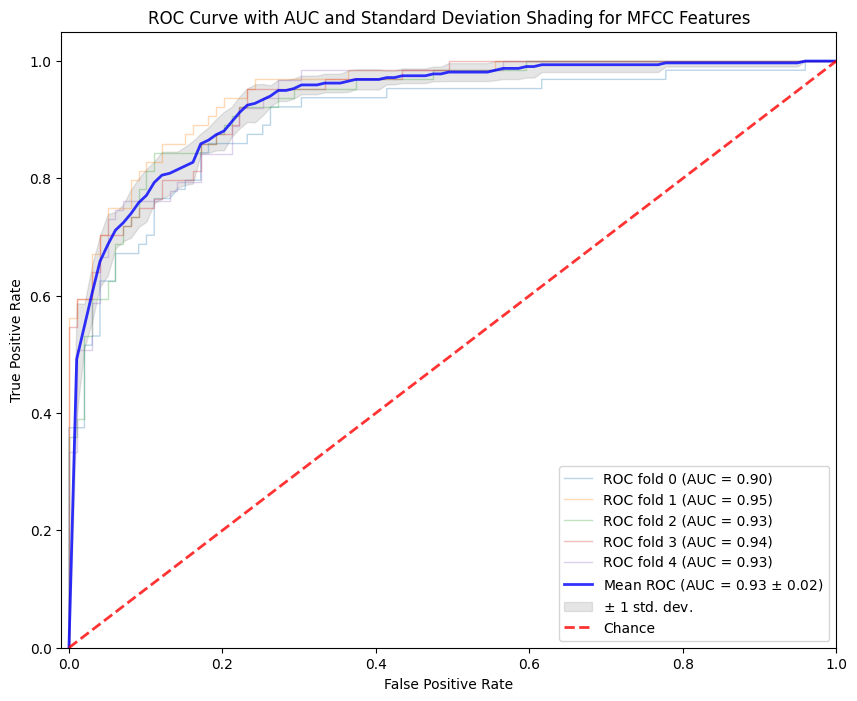

Fitting 5 folds for each of 50 candidates, totalling 250 fits


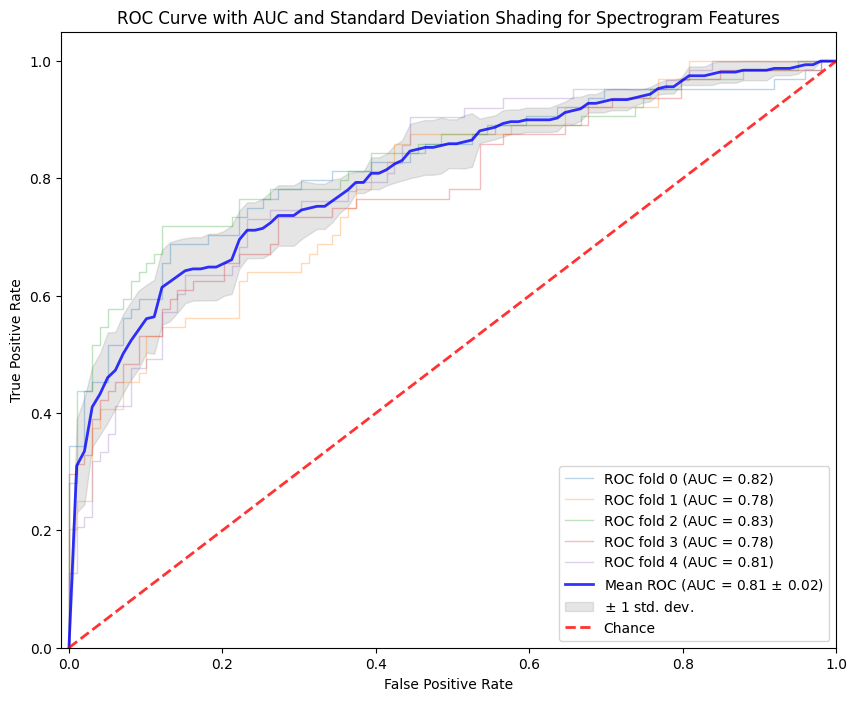

Fitting 5 folds for each of 50 candidates, totalling 250 fits


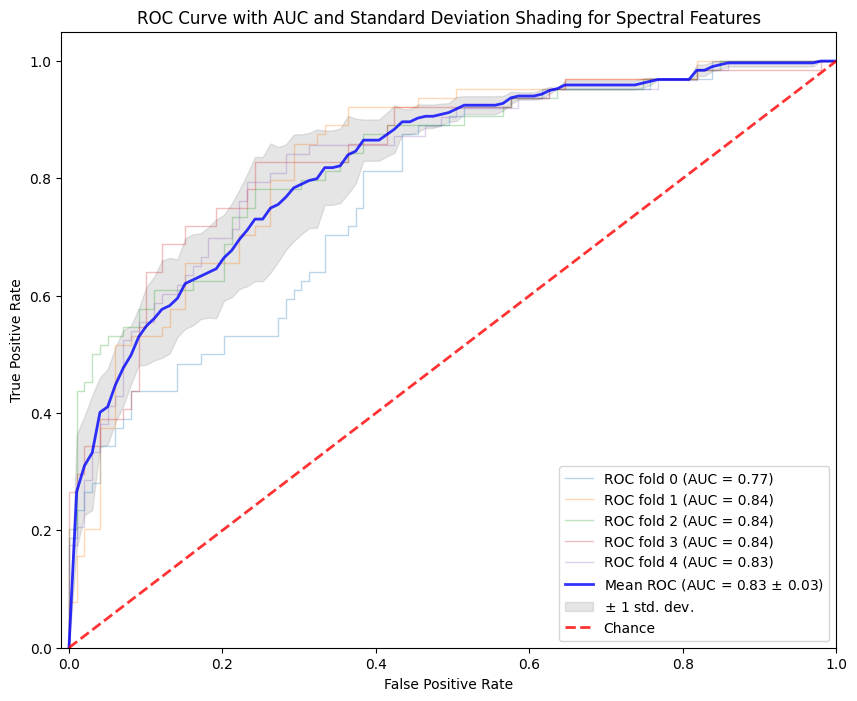

Fitting 5 folds for each of 50 candidates, totalling 250 fits


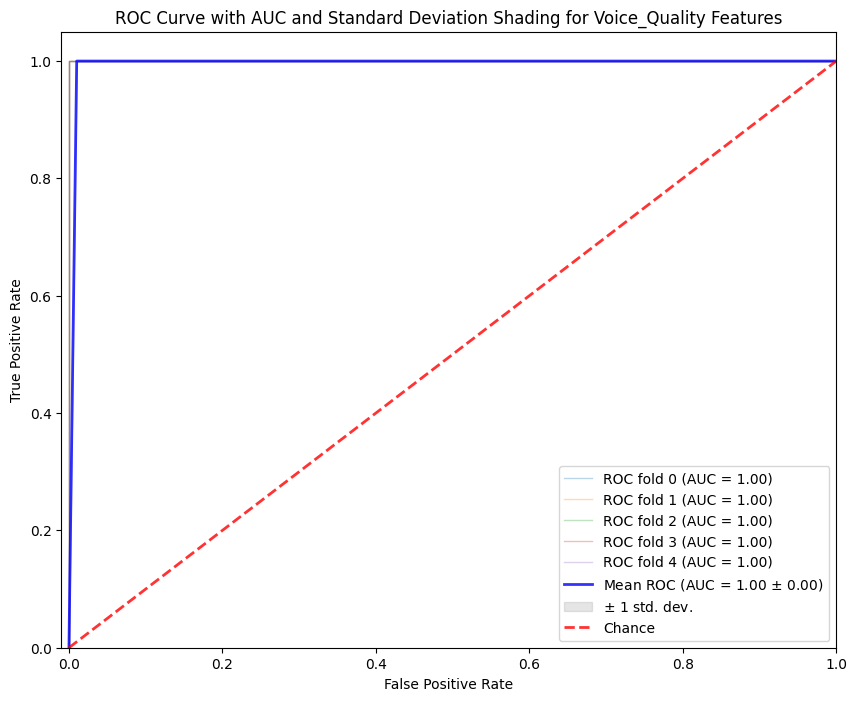

     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.833333   0.883333  0.6625  0.757143  0.920867  0.649391   
1    Spectrogram  0.823529   0.823529  0.7000  0.756757  0.853629  0.624758   
2       Spectral  0.789216   0.784615  0.6375  0.703448  0.856956  0.549689   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

   Log-Loss  Cohen's Kappa       MAE  Specificity  
0  0.461770       0.634177  0.166667     0.943548  
1  0.464068       0.619718  0.176471     0.903226  
2  0.477061       0.542649  0.210784     0.887097  
3  0.048149       1.000000  0.000000     1.000000  


In [11]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve, RocCurveDisplay
)
from scipy.stats import randint


# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier with RandomizedSearchCV
    clf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_clf = random_search.best_estimator_

    # Perform Stratified K-Fold cross-validation for ROC curve
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        best_clf.fit(X_train.iloc[train], y_train.iloc[train])
        y_pred_proba = best_clf.predict_proba(X_train.iloc[test])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test], y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test], y_pred_proba)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation Shading for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate metrics using the full test set
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
    })

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_with_roc1.csv', index=False)


In [14]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_with_roc1.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.833333   0.883333  0.6625  0.757143  0.920867  0.649391   
1    Spectrogram  0.823529   0.823529  0.7000  0.756757  0.853629  0.624758   
2       Spectral  0.789216   0.784615  0.6375  0.703448  0.856956  0.549689   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

   Log-Loss  Cohen's Kappa       MAE  Specificity  
0  0.461770       0.634177  0.166667     0.943548  
1  0.464068       0.619718  0.176471     0.903226  
2  0.477061       0.542649  0.210784     0.887097  
3  0.048149       1.000000  0.000000     1.000000

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms

# Load the dataset
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define Genetic Algorithm Components
# Define the fitness function
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_features) == 0:
        return 0,
    
    X_selected = X.iloc[:, selected_features]
    classifier = RandomForestClassifier(n_estimators=50, random_state=42)
    scores = cross_val_score(classifier, X_selected, y, cv=5, scoring='accuracy')
    return scores.mean(),

# Define the individual and population
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define the toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
def main():
    population = toolbox.population(n=50)
    ngen, cxpb, mutpb = 20, 0.5, 0.2

    result, _ = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                                    stats=None, halloffame=None, verbose=True)
    
    top_individual = tools.selBest(population, k=1)[0]
    selected_features = [i for i, bit in enumerate(top_individual) if bit == 1]
    print("Selected Features:", selected_features)
    return top_individual

best_individual = main()


gen	nevals
0  	50    
1  	28    
2  	34    
3  	30    
4  	31    
5  	34    
6  	21    
7  	30    
8  	35    
9  	34    
10 	31    
11 	34    
12 	39    
13 	30    
14 	35    
15 	29    
16 	31    
17 	36    
18 	33    
19 	35    
20 	29    
Selected Features: [3, 5, 10, 11, 19, 22, 23, 29, 31, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 47, 48, 50, 51, 53]


In [19]:
def main():
    population = toolbox.population(n=50)
    ngen, cxpb, mutpb = 20, 0.5, 0.2
    result, _ = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                                    stats=None, halloffame=None, verbose=True)
        top_individual = tools.selBest(population, k=1)[0]
    selected_features = [i for i, bit in enumerate(top_individual) if bit == 1]
    
    # Print feature names instead of indices
    selected_feature_names = X.columns[selected_features]
    print("Selected Features (Indices):", selected_features)
    print("Selected Features (Names):", list(selected_feature_names))
        return top_individual

best_individual = main()


gen	nevals
0  	50    
1  	34    
2  	33    
3  	31    
4  	30    
5  	22    
6  	27    
7  	30    
8  	37    
9  	29    
10 	38    
11 	31    
12 	25    
13 	36    
14 	23    
15 	28    
16 	31    
17 	22    
18 	32    
19 	28    
20 	25    
Selected Features (Indices): [0, 2, 3, 4, 9, 10, 11, 12, 14, 15, 16, 17, 19, 24, 25, 26, 29, 31, 33, 35, 36, 38, 39, 40, 41, 42, 46, 48, 50, 51, 52]
Selected Features (Names): ['mfcc_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 'mfcc_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 'mfcc_delta_7', 'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_delta2_10', 'mfcc_delta_11', 'mfcc_12', 'mfcc_delta2_12', 'mfcc_13', 'mfcc_delta2_13', 'mel_spectrogram', 'chroma_stft', 'rmse', 'spectral_contrast', 'spectral_rolloff', 'jitter_local', 'f0_mean', 'hnr', 'entropy']


Fitting 5 folds for each of 50 candidates, totalling 250 fits


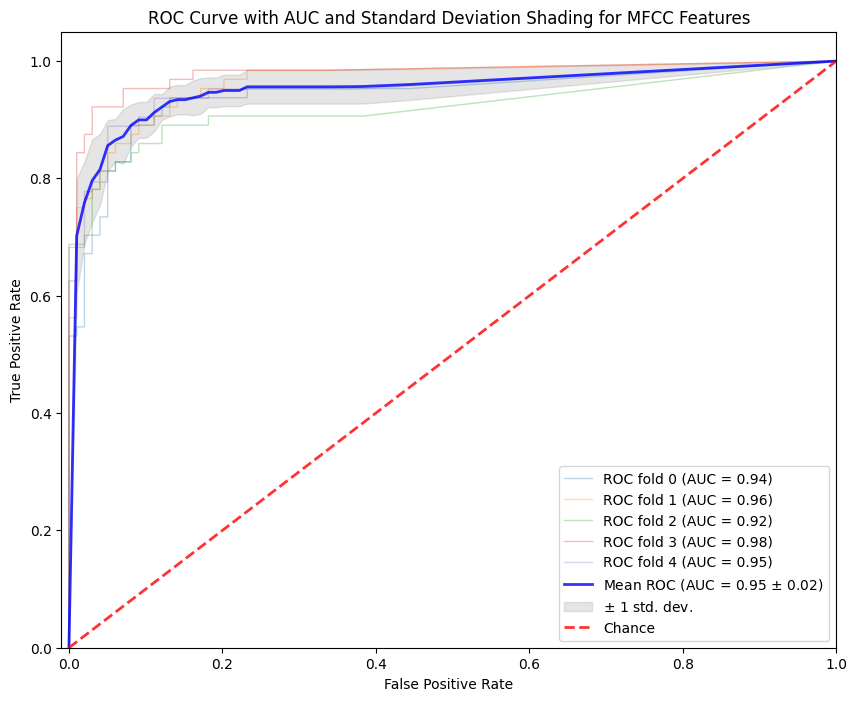


Feature Set: MFCC
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Training time (seconds): 2.97395920753479
Testing time (seconds): 0.007189512252807617
Accuracy: 0.8970588235294118
Precision: 0.9154929577464789
Recall: 0.8125
F1 Score: 0.8609271523178808
ROC AUC Score: 0.960483870967742
Matthews Correlation Coefficient (MCC): 0.7831742046608074
Log-Loss: 0.5480574817470805
Cohen's Kappa: 0.7796749639991771
Mean Absolute Error (MAE): 0.10294117647058823
Specificity: 0.9516129032258065
Confusion Matrix:
 [[118   6]
 [ 15  65]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


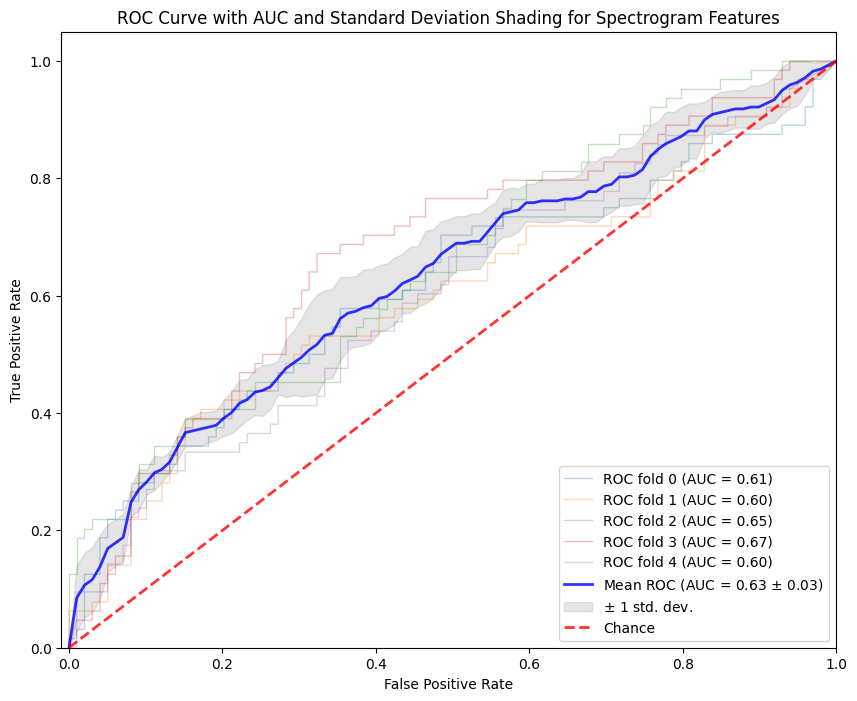


Feature Set: Spectrogram
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Training time (seconds): 0.5919265747070312
Testing time (seconds): 0.009517192840576172
Accuracy: 0.6519607843137255
Precision: 0.6046511627906976
Recall: 0.325
F1 Score: 0.42276422764227645
ROC AUC Score: 0.6804939516129032
Matthews Correlation Coefficient (MCC): 0.2249276812223015
Log-Loss: 0.8058096271466069
Cohen's Kappa: 0.20470019767186476
Mean Absolute Error (MAE): 0.3480392156862745
Specificity: 0.8629032258064516
Confusion Matrix:
 [[107  17]
 [ 54  26]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


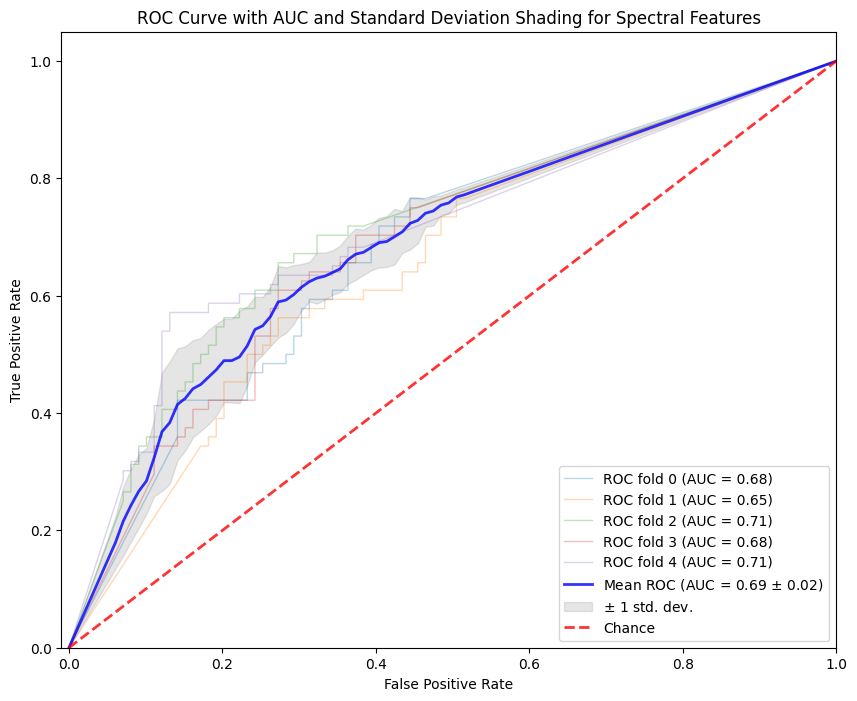


Feature Set: Spectral
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
Training time (seconds): 0.4672985076904297
Testing time (seconds): 0.004412174224853516
Accuracy: 0.6323529411764706
Precision: 0.5333333333333333
Recall: 0.5
F1 Score: 0.5161290322580646
ROC AUC Score: 0.657258064516129
Matthews Correlation Coefficient (MCC): 0.22048163877806143
Log-Loss: 7.29864924082217
Cohen's Kappa: 0.22018348623853212
Mean Absolute Error (MAE): 0.36764705882352944
Specificity: 0.717741935483871
Confusion Matrix:
 [[89 35]
 [40 40]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


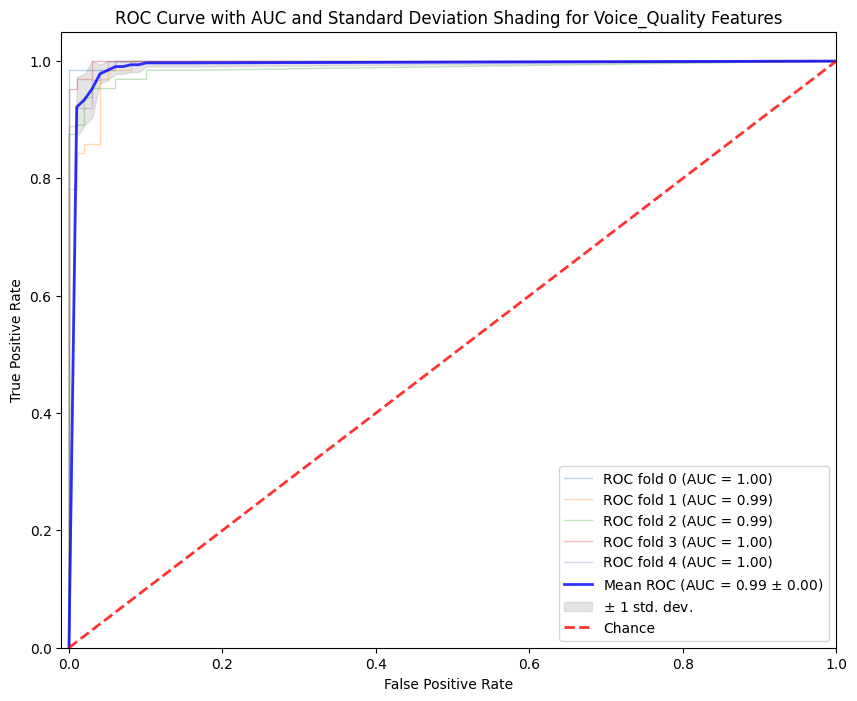


Feature Set: Voice_Quality
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Training time (seconds): 0.43855810165405273
Testing time (seconds): 0.0030541419982910156
Accuracy: 0.9803921568627451
Precision: 0.9871794871794872
Recall: 0.9625
F1 Score: 0.9746835443037976
ROC AUC Score: 0.9969758064516129
Matthews Correlation Coefficient (MCC): 0.9588923177999537
Log-Loss: 0.06730391029586709
Cohen's Kappa: 0.9586877278250304
Mean Absolute Error (MAE): 0.0196078431372549
Specificity: 0.9919354838709677
Confusion Matrix:
 [[123   1]
 [  3  77]]
     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.897059   0.915493  0.8125  0.860927  0.960484  0.783174   
1    Spectrogram  0.651961   0.604651  0.3250  0.422764  0.680494  0.224928   
2       Spectral  0.632353   0.533333  0.5000  0.516129  0.657258  0.220482   
3  Voice_Quality  0.980392   0.987179  0.9625  0.974684  0.996976  0.958892   

   Log-Loss  Cohen's Ka

In [28]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
from scipy.stats import randint
import matplotlib.pyplot as plt
from scipy import interp

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the KNN classifier
    clf = KNeighborsClassifier()
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
 
    # Perform Stratified K-Fold cross-validation for ROC curve
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        best_clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_pred_proba_cv = best_clf.predict_proba(X_train.iloc[test_idx])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test_idx], y_pred_proba_cv)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )   

    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation Shading for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
})
# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('knn_feature_comparison_results.csv', index=False)


In [29]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'knn_feature_comparison_results.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.897059   0.915493  0.8125  0.860927  0.960484  0.783174   
1    Spectrogram  0.651961   0.604651  0.3250  0.422764  0.680494  0.224928   
2       Spectral  0.632353   0.533333  0.5000  0.516129  0.657258  0.220482   
3  Voice_Quality  0.980392   0.987179  0.9625  0.974684  0.996976  0.958892   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  Testing Time  
0  0.548057       0.779675  0.102941     0.951613       2.973959      0.007190  
1  0.805810       0.204700  0.348039     0.862903       0.591927      0.009517  
2  7.298649       0.220183  0.367647     0.717742       0.467299      0.004412  
3  0.067304       0.958688  0.019608     0.991935       0.438558      0.003054

Fitting 5 folds for each of 50 candidates, totalling 250 fits


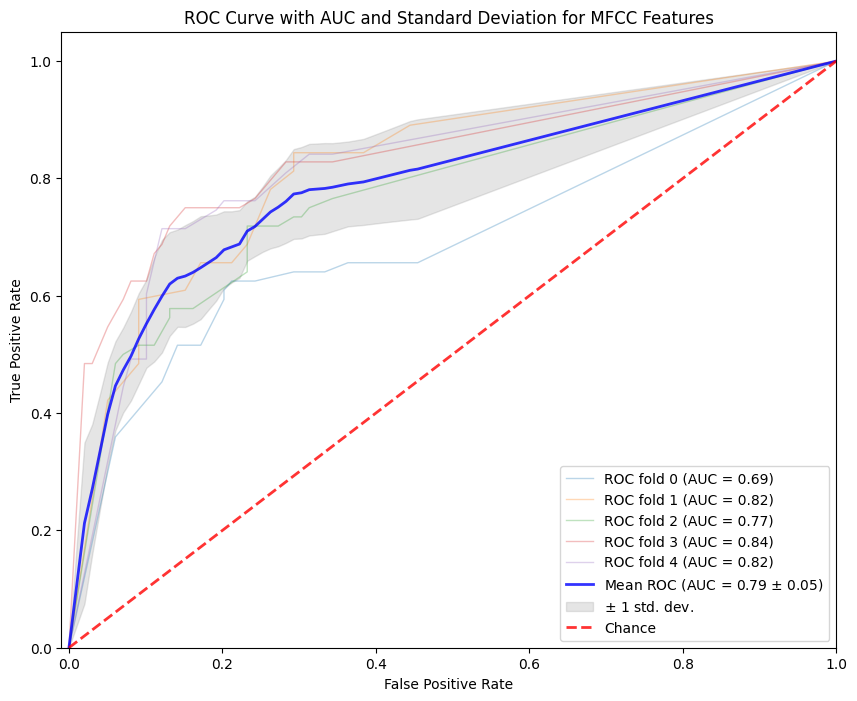


Feature Set: MFCC
Best Parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 4, 'min_samples_split': 19}
Training time (seconds): 8.901870250701904
Testing time (seconds): 0.01428985595703125
Accuracy: 0.7009803921568627
Precision: 0.6043956043956044
Recall: 0.6875
F1 Score: 0.6432748538011696
ROC AUC Score: 0.7540322580645162
Matthews Correlation Coefficient (MCC): 0.39010405784421154
Log-Loss: 5.724717846517075
Cohen's Kappa: 0.3877189529620153
Mean Absolute Error (MAE): 0.29901960784313725
Specificity: 0.7096774193548387
Confusion Matrix:
 [[88 36]
 [25 55]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


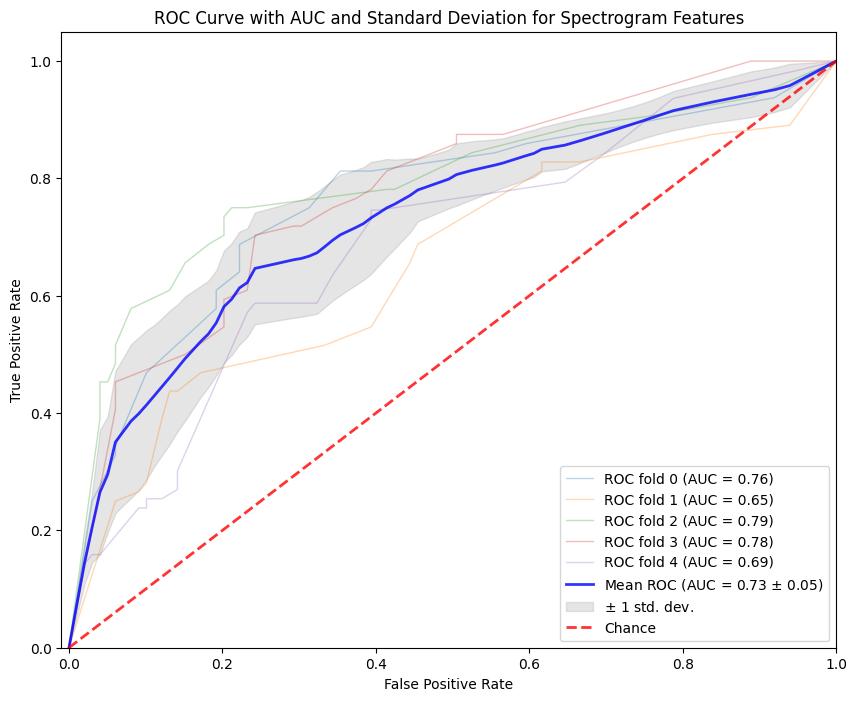


Feature Set: Spectrogram
Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 3}
Training time (seconds): 1.9127693176269531
Testing time (seconds): 0.004000186920166016
Accuracy: 0.7352941176470589
Precision: 0.7321428571428571
Recall: 0.5125
F1 Score: 0.6029411764705882
ROC AUC Score: 0.7562500000000001
Matthews Correlation Coefficient (MCC): 0.4283497462430543
Log-Loss: 1.74077418496097
Cohen's Kappa: 0.4135434412265758
Mean Absolute Error (MAE): 0.2647058823529412
Specificity: 0.8790322580645161
Confusion Matrix:
 [[109  15]
 [ 39  41]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


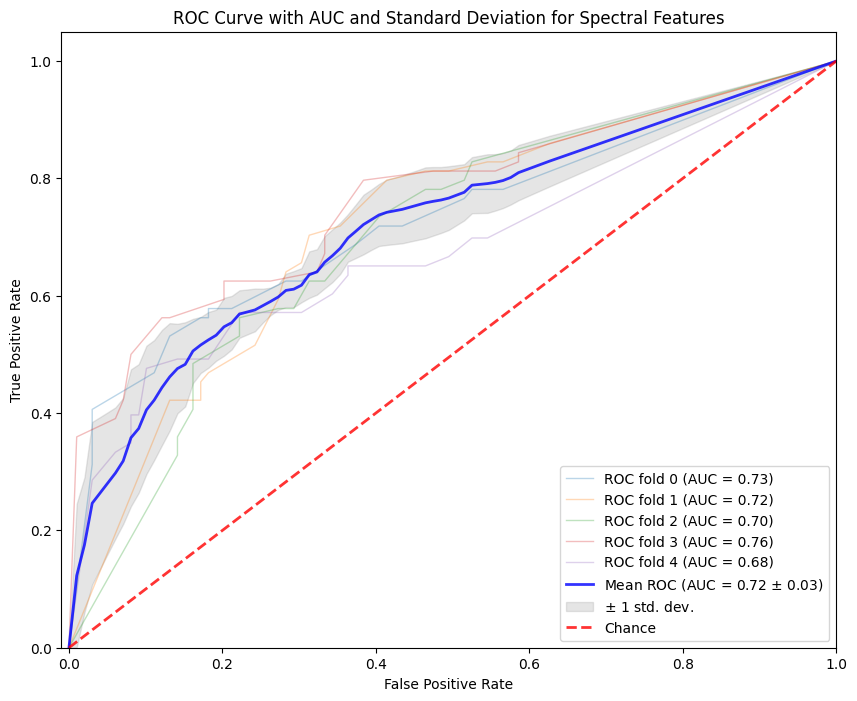


Feature Set: Spectral
Best Parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 2}
Training time (seconds): 2.674346446990967
Testing time (seconds): 0.003998994827270508
Accuracy: 0.7156862745098039
Precision: 0.6410256410256411
Recall: 0.625
F1 Score: 0.6329113924050633
ROC AUC Score: 0.738508064516129
Matthews Correlation Coefficient (MCC): 0.4010576234144293
Log-Loss: 3.5848020887825225
Cohen's Kappa: 0.4009720534629405
Mean Absolute Error (MAE): 0.28431372549019607
Specificity: 0.7741935483870968
Confusion Matrix:
 [[96 28]
 [30 50]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


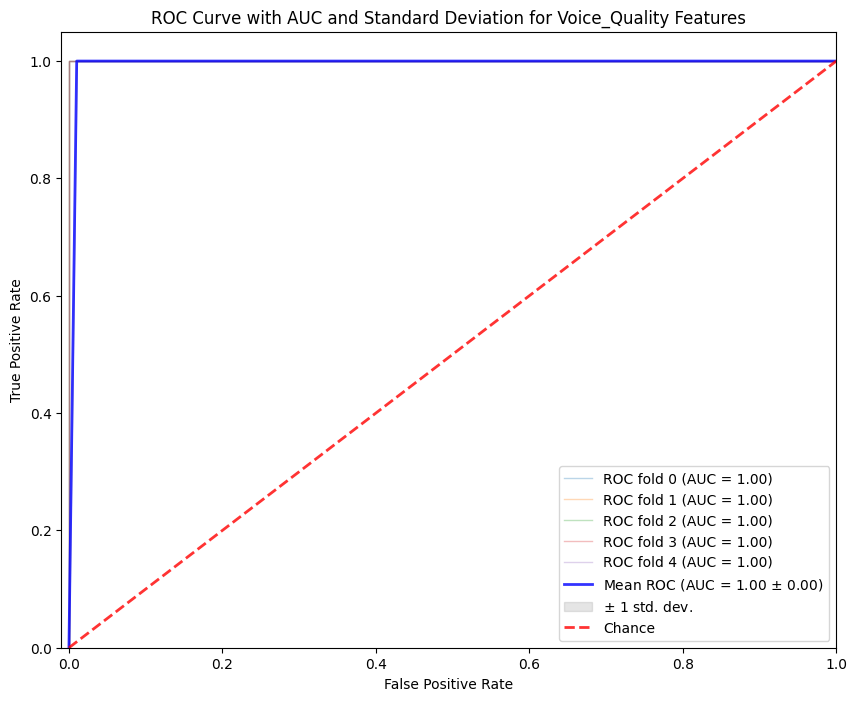


Feature Set: Voice_Quality
Best Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 19}
Training time (seconds): 1.3241052627563477
Testing time (seconds): 0.004000186920166016
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 2.220446049250313e-16
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.700980   0.604396  0.6875  0.643275  0.754032  0.390104   
1    Spectrogram  0.735294   0.732143  0.5125  0.602941  0.756250  0.428350   
2       Spectral  0.715686   0.641026  0.6250  0.632911  0.738508  0.401058   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  5.724718e+00       0.387719  0.299020     0.709677

In [21]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy import interp

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the Decision Tree classifier
    clf = DecisionTreeClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # ROC Curve with Standard Deviation
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        best_clf.fit(X_train.iloc[train], y_train.iloc[train])
        y_pred_proba_cv = best_clf.predict_proba(X_train.iloc[test])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test], y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test], y_pred_proba_cv)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('dt_feature_comparison_results.csv', index=False)


In [30]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'dt_feature_comparison_results.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.700980   0.604396  0.6875  0.643275  0.754032  0.390104   
1    Spectrogram  0.735294   0.732143  0.5125  0.602941  0.756250  0.428350   
2       Spectral  0.715686   0.641026  0.6250  0.632911  0.738508  0.401058   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  5.724718e+00       0.387719  0.299020     0.709677       8.901870   
1  1.740774e+00       0.413543  0.264706     0.879032       1.912769   
2  3.584802e+00       0.400972  0.284314     0.774194       2.674346   
3  2.220446e-16       1.000000  0.000000     1.000000       1.324105   

   Testing Time  
0      0.014290  
1      0.004000  
2      0.003999  
3      0.004000

Fitting 5 folds for each of 50 candidates, totalling 250 fits


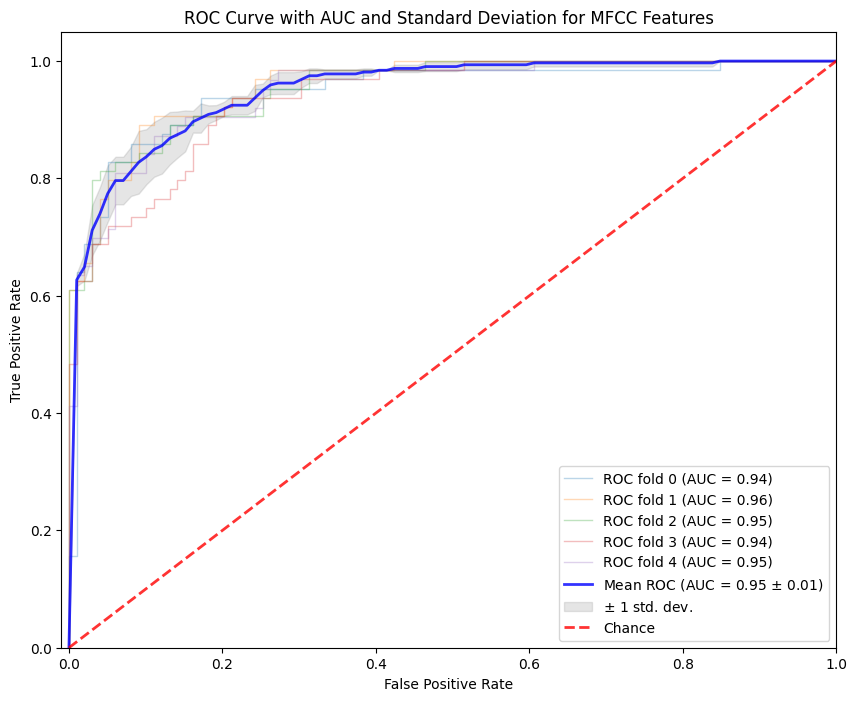


Feature Set: MFCC
Best Parameters: {'colsample_bytree': 0.6579579488364892, 'learning_rate': 0.1568358280832689, 'max_depth': 8, 'n_estimators': 209, 'subsample': 0.8370786895517575}
Training time (seconds): 39.99423003196716
Testing time (seconds): 0.04277515411376953
Accuracy: 0.8480392156862745
Precision: 0.8266666666666667
Recall: 0.775
F1 Score: 0.8000000000000002
ROC AUC Score: 0.9424395161290323
Matthews Correlation Coefficient (MCC): 0.6785934882391447
Log-Loss: 0.30729054397464556
Cohen's Kappa: 0.6776758409785932
Mean Absolute Error (MAE): 0.15196078431372548
Specificity: 0.8951612903225806
Confusion Matrix:
 [[111  13]
 [ 18  62]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


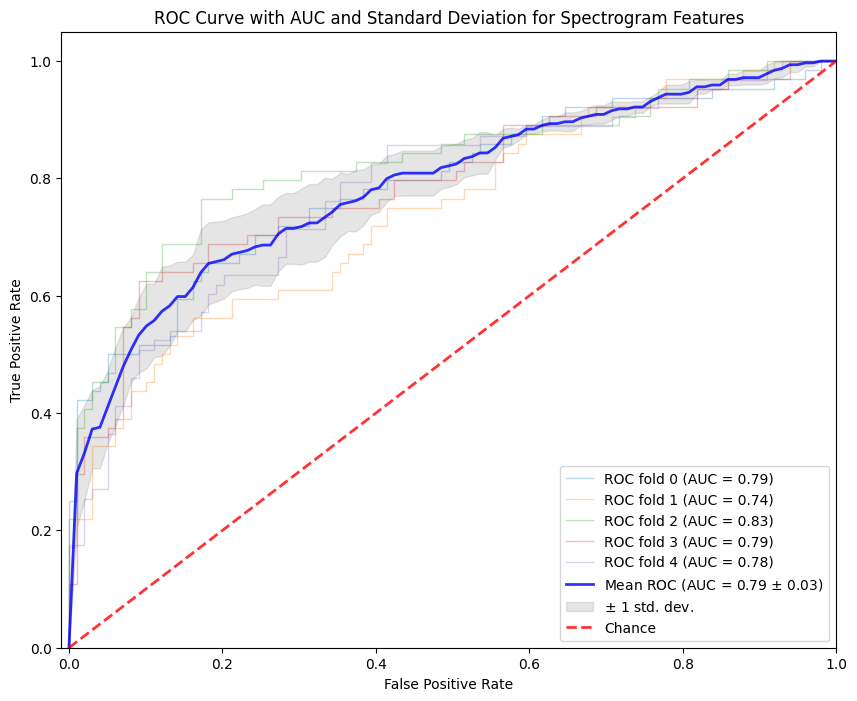


Feature Set: Spectrogram
Best Parameters: {'colsample_bytree': 0.8842651558743149, 'learning_rate': 0.0432672462435494, 'max_depth': 15, 'n_estimators': 228, 'subsample': 0.6125716742746937}
Training time (seconds): 9.702598333358765
Testing time (seconds): 0.008999824523925781
Accuracy: 0.7794117647058824
Precision: 0.7108433734939759
Recall: 0.7375
F1 Score: 0.7239263803680982
ROC AUC Score: 0.8402217741935485
Matthews Correlation Coefficient (MCC): 0.5406103718517798
Log-Loss: 0.4953472192847277
Cohen's Kappa: 0.5403564990987382
Mean Absolute Error (MAE): 0.22058823529411764
Specificity: 0.8064516129032258
Confusion Matrix:
 [[100  24]
 [ 21  59]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


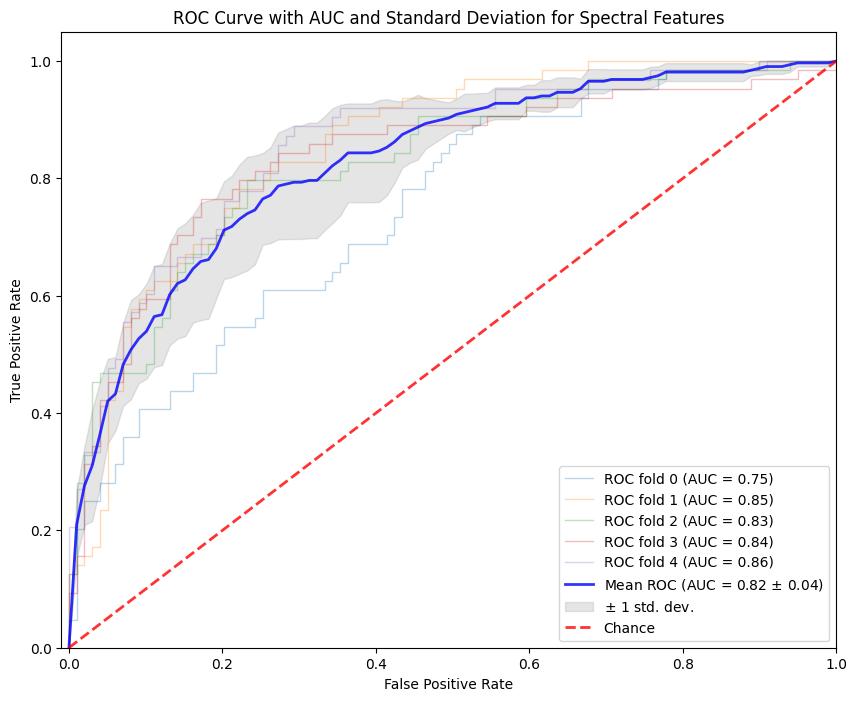


Feature Set: Spectral
Best Parameters: {'colsample_bytree': 0.9085081386743783, 'learning_rate': 0.03221339552022711, 'max_depth': 9, 'n_estimators': 299, 'subsample': 0.6463476238100518}
Training time (seconds): 14.964829921722412
Testing time (seconds): 0.015000104904174805
Accuracy: 0.8137254901960784
Precision: 0.8
Recall: 0.7
F1 Score: 0.7466666666666666
ROC AUC Score: 0.8751008064516129
Matthews Correlation Coefficient (MCC): 0.6037596858893842
Log-Loss: 0.42841801883613706
Cohen's Kappa: 0.6004123711340206
Mean Absolute Error (MAE): 0.18627450980392157
Specificity: 0.8870967741935484
Confusion Matrix:
 [[110  14]
 [ 24  56]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


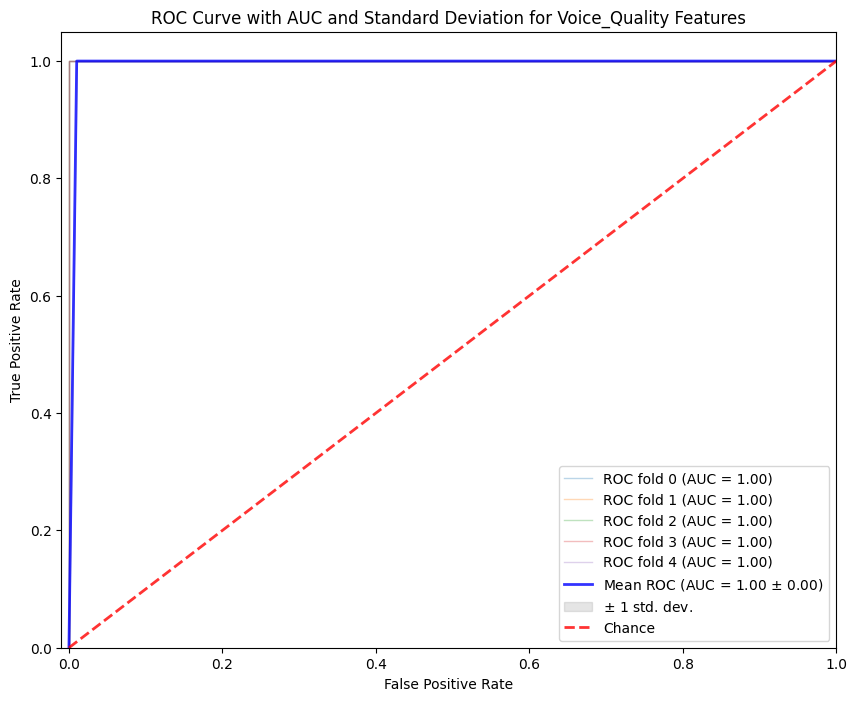


Feature Set: Voice_Quality
Best Parameters: {'colsample_bytree': 0.749816047538945, 'learning_rate': 0.2952142919229748, 'max_depth': 13, 'n_estimators': 121, 'subsample': 0.8394633936788146}
Training time (seconds): 4.275148153305054
Testing time (seconds): 0.00835561752319336
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 0.004937594500314983
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.848039   0.826667  0.7750  0.800000  0.942440  0.678593   
1    Spectrogram  0.779412   0.710843  0.7375  0.723926  0.840222  0.540610   
2       Spectral  0.813725   0.800000  0.7000  0.746667  0.875101  0.603760   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  

In [23]:
import pandas as pd
import numpy as np
import time
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from scipy import interp

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the XGBoost classifier
    clf = XGBClassifier(eval_metric='logloss', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )

    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # ROC Curve with Standard Deviation
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        best_clf.fit(X_train.iloc[train], y_train.iloc[train])
        y_pred_proba_cv = best_clf.predict_proba(X_train.iloc[test])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test], y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test], y_pred_proba_cv)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('XGB_feature_comparison_results.csv', index=False)


In [31]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'XGB_feature_comparison_results.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.848039   0.826667  0.7750  0.800000  0.942440  0.678593   
1    Spectrogram  0.779412   0.710843  0.7375  0.723926  0.840222  0.540610   
2       Spectral  0.813725   0.800000  0.7000  0.746667  0.875101  0.603760   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  Testing Time  
0  0.307291       0.677676  0.151961     0.895161      39.994230      0.042775  
1  0.495347       0.540356  0.220588     0.806452       9.702598      0.009000  
2  0.428418       0.600412  0.186275     0.887097      14.964830      0.015000  
3  0.004938       1.000000  0.000000     1.000000       4.275148      0.008356

In [4]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Define the labels
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'base_estimator__max_depth': randint(1, 10)  # Assuming base estimator is a decision tree
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the AdaBoost classifier with DecisionTree as base estimator
    base_estimator = DecisionTreeClassifier(random_state=42)
    clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
    
    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Train the model with RandomizedSearchCV
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set with RandomizedSearchCV
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

# Initialize AdaBoost classifier with DecisionTree as base estimator
clf_all = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# Set up RandomizedSearchCV for all features
random_search_all = RandomizedSearchCV(
    estimator=clf_all, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

# Train the model with RandomizedSearchCV
start_train_all = time.time()
random_search_all.fit(X_train_all, y_train_all)
end_train_all = time.time()

best_clf_all = random_search_all.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)[:, 1]
end_test_all = time.time()

accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all)
recall_all = recall_score(y_test_all, y_pred_all)
f1_all = f1_score(y_test_all, y_pred_all)
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_adaboost_optimized.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: MFCC
Training time (seconds): 332.4987940788269
Testing time (seconds): 0.06311273574829102
Accuracy: 0.8382352941176471
Precision: 0.8309859154929577
Recall: 0.7375
F1 Score: 0.7814569536423841
ROC AUC Score: 0.9183467741935484
Matthews Correlation Coefficient (MCC): 0.6567091352010676
Log-Loss: 0.4333861110385535
Cohen's Kappa: 0.6537749434272784
Mean Absolute Error (MAE): 0.16176470588235295
Specificity: 0.9032258064516129
Confusion Matrix:
 [[112  12]
 [ 21  59]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Spectrogram
Training time (seconds): 57.86333918571472
Testing time (seconds): 0.0688314437866211
Accuracy: 0.7843137254901961
Precision: 0.7368421052631579
Recall: 0.7
F1 Score: 0.717948717948718
ROC AUC Score: 0.8240927419354838
Matthews Correlation Coefficient (MCC): 0.5439999157345385
Log-Loss: 2.1442650712851403
Cohen's Kappa: 0.5435313262815297
Mean Absolute Error (MAE): 0.21568627450980393
Specificity: 0.8387096774193549
Confusion Matrix:
 [[104  20]
 [ 24  56]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Spectral
Training time (seconds): 89.12650060653687
Testing time (seconds): 0.07638263702392578
Accuracy: 0.8137254901960784
Precision: 0.828125
Recall: 0.6625
F1 Score: 0.736111111111111
ROC AUC Score: 0.8954637096774194
Matthews Correlation Coefficient (MCC): 0.6037470899930825
Log-Loss: 0.4005510456738996
Cohen's Kappa: 0.5948996655518395
Mean Absolute Error (MAE): 0.18627450980392157
Specificity: 0.9112903225806451
Confusion Matrix:
 [[113  11]
 [ 27  53]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Voice_Quality
Training time (seconds): 9.564367532730103
Testing time (seconds): 0.002035379409790039
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 2.2204460492503136e-16
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: All Combined
Training time (seconds): 183.141850233078
Testing time (seconds): 0.04003763198852539
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 0.520244586721715
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.838235   0.830986  0.7375  0.781457  0.918347  0.656709   
1    Spectrogram  0.784314   0.736842  0.7000  0.717949  0.824093  0.544000   
2       Spectral  0.813725   0.828125  0.6625  0.736111  0.895464  0.603747   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   
4   All Combined  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  4.333861e-01       0.653775  0.161765     0.903226     332.498794   
1  2.144265e+

In [6]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_adaboost_optimized.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.838235   0.830986  0.7375  0.781457  0.918347  0.656709   
1    Spectrogram  0.784314   0.736842  0.7000  0.717949  0.824093  0.544000   
2       Spectral  0.813725   0.828125  0.6625  0.736111  0.895464  0.603747   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   
4   All Combined  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  4.333861e-01       0.653775  0.161765     0.903226     332.498794   
1  2.144265e+00       0.543531  0.215686     0.838710      57.863339   
2  4.005510e-01       0.594900  0.186275     0.911290      89.126501   
3  2.220446e-16       1.000000  0.000000     1.000000       9.564368   
4  5.202446e-01       1.000000  0.000000     1.000000     183.141850   

   Testing Time  
0      0.063113  
1      0.068831  
2      0.076383  
3      0.002035  
4      0.040038

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

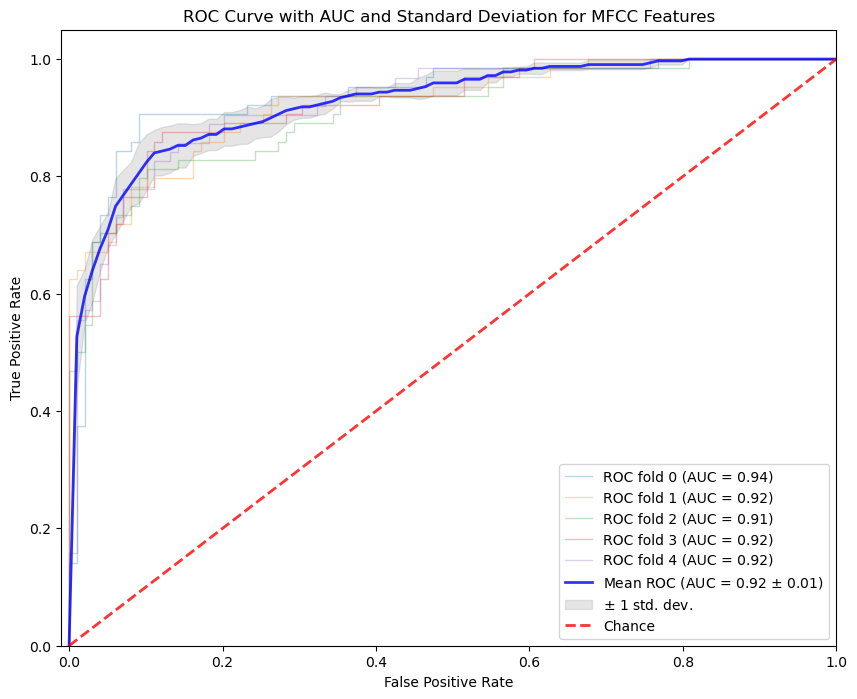


Feature Set: MFCC
Best Parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.7707850486168975, 'n_estimators': 267}
Training time (seconds): 422.6068048477173
Testing time (seconds): 0.11104011535644531
Accuracy: 0.8382352941176471
Precision: 0.821917808219178
Recall: 0.75
F1 Score: 0.7843137254901962
ROC AUC Score: 0.9165322580645161
Matthews Correlation Coefficient (MCC): 0.6570933318565289
Log-Loss: 0.5448173127608759
Cohen's Kappa: 0.6553348351423305
Mean Absolute Error (MAE): 0.16176470588235295
Specificity: 0.8951612903225806
Confusion Matrix:
 [[111  13]
 [ 20  60]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

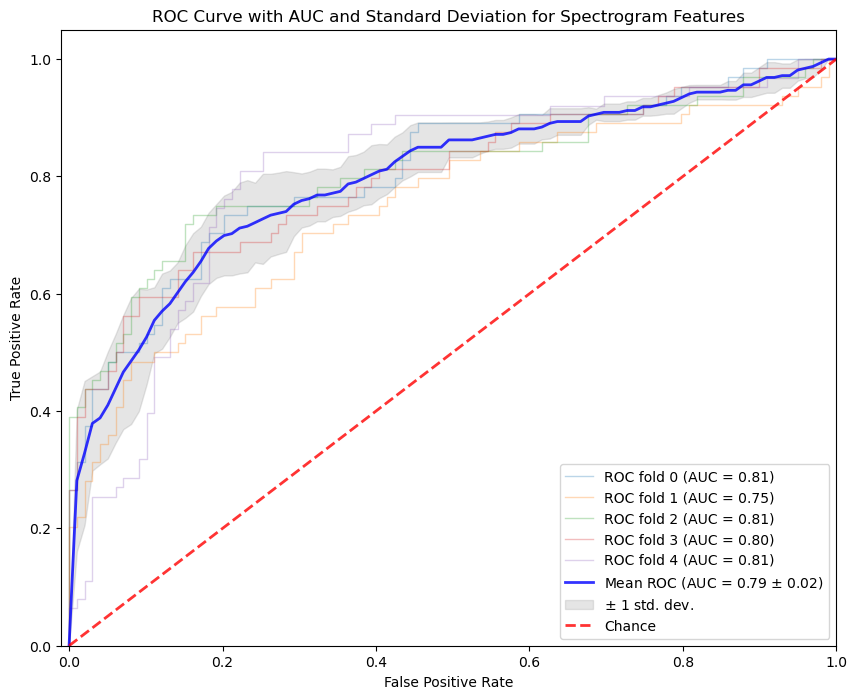


Feature Set: Spectrogram
Best Parameters: {'base_estimator__max_depth': 8, 'learning_rate': 0.6608884729488529, 'n_estimators': 102}
Training time (seconds): 67.30587863922119
Testing time (seconds): 0.04643440246582031
Accuracy: 0.7745098039215687
Precision: 0.7236842105263158
Recall: 0.6875
F1 Score: 0.7051282051282051
ROC AUC Score: 0.8191532258064516
Matthews Correlation Coefficient (MCC): 0.5232334518853907
Log-Loss: 1.620883815955452
Cohen's Kappa: 0.5227827502034175
Mean Absolute Error (MAE): 0.22549019607843138
Specificity: 0.8306451612903226
Confusion Matrix:
 [[103  21]
 [ 25  55]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

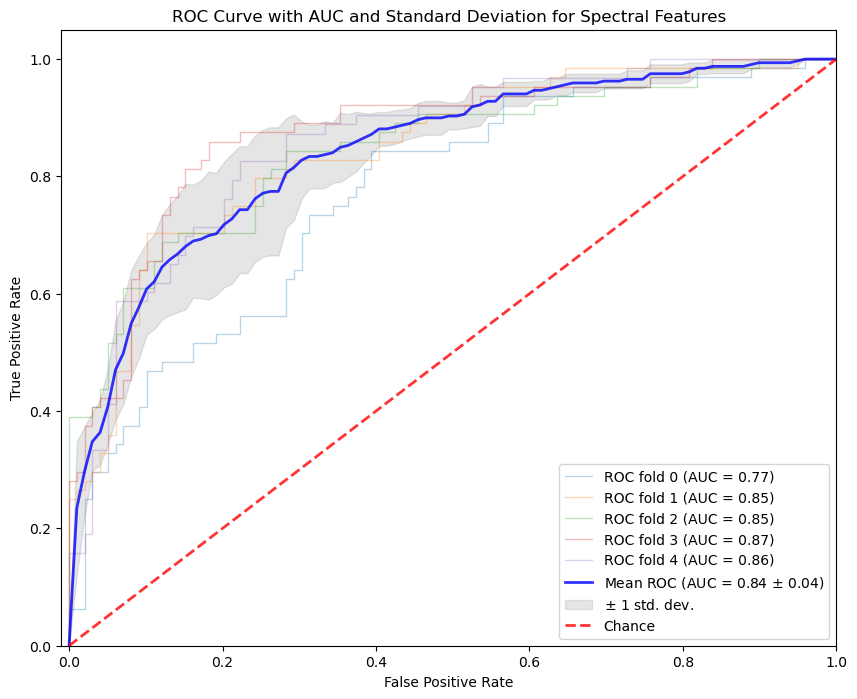


Feature Set: Spectral
Best Parameters: {'base_estimator__max_depth': 7, 'learning_rate': 0.9060912999234932, 'n_estimators': 280}
Training time (seconds): 118.52142214775085
Testing time (seconds): 0.08337211608886719
Accuracy: 0.8431372549019608
Precision: 0.9
Recall: 0.675
F1 Score: 0.7714285714285714
ROC AUC Score: 0.8879032258064516
Matthews Correlation Coefficient (MCC): 0.6714262223379504
Log-Loss: 0.7545071238058483
Cohen's Kappa: 0.6556962025316455
Mean Absolute Error (MAE): 0.1568627450980392
Specificity: 0.9516129032258065
Confusion Matrix:
 [[118   6]
 [ 26  54]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

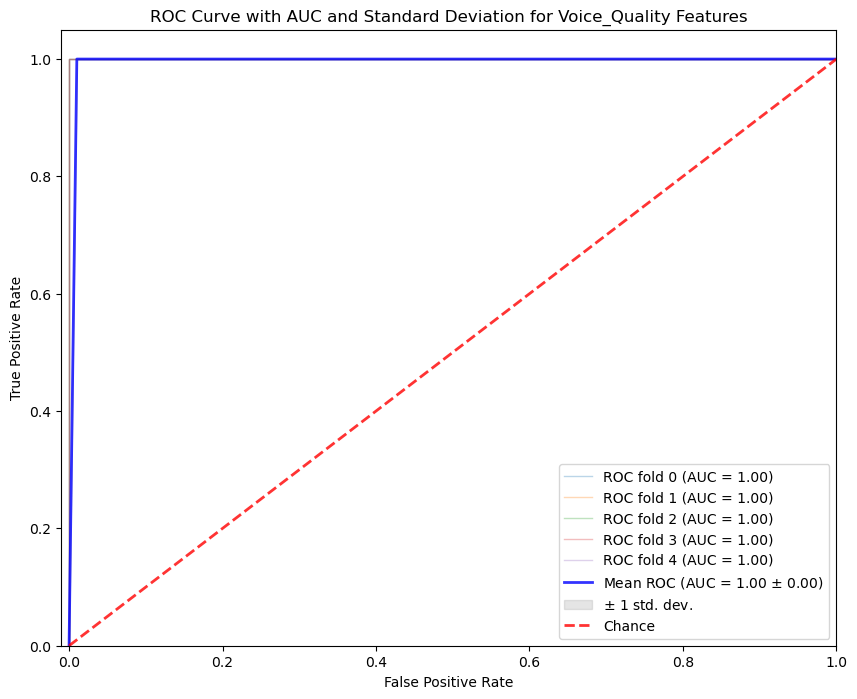


Feature Set: Voice_Quality
Best Parameters: {'base_estimator__max_depth': 7, 'learning_rate': 0.8065429868602328, 'n_estimators': 64}
Training time (seconds): 16.077825784683228
Testing time (seconds): 0.0019948482513427734
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 2.2204460492503136e-16
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.838235   0.821918  0.7500  0.784314  0.916532  0.657093   
1    Spectrogram  0.774510   0.723684  0.6875  0.705128  0.819153  0.523233   
2       Spectral  0.843137   0.900000  0.6750  0.771429  0.887903  0.671426   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  5.448173e-01       0.655335  0.161765     0.

In [5]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from scipy import interp

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 1),
    'base_estimator__max_depth': randint(1, 10)
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the AdaBoost classifier with DecisionTree as base estimator
    base_estimator = DecisionTreeClassifier(random_state=42)
    clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
    
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )

    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # ROC Curve with Standard Deviation
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        best_clf.fit(X_train.iloc[train], y_train.iloc[train])
        y_pred_proba_cv = best_clf.predict_proba(X_train.iloc[test])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test], y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test], y_pred_proba_cv)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('AdaBoost_feature_comparison_results.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

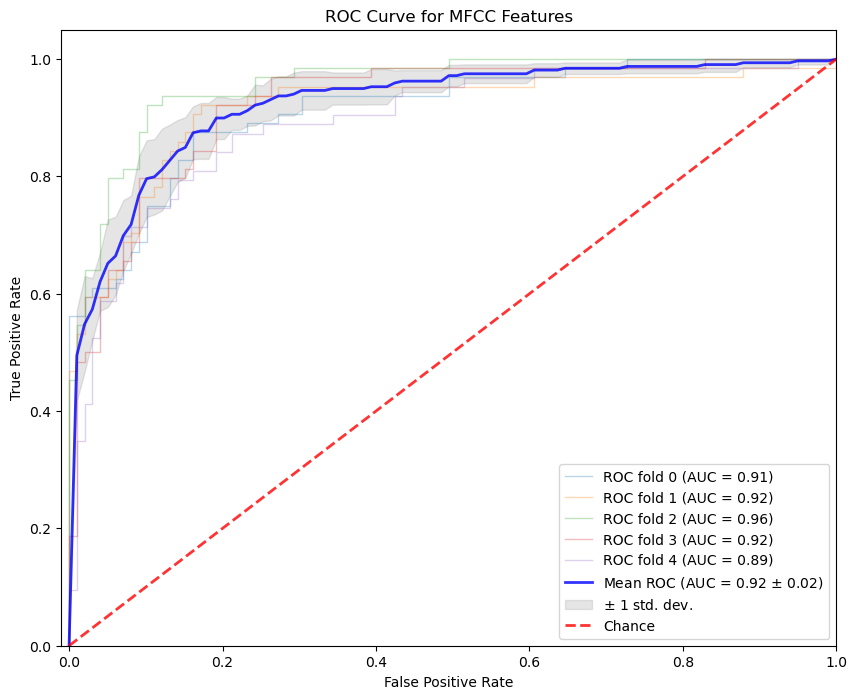

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

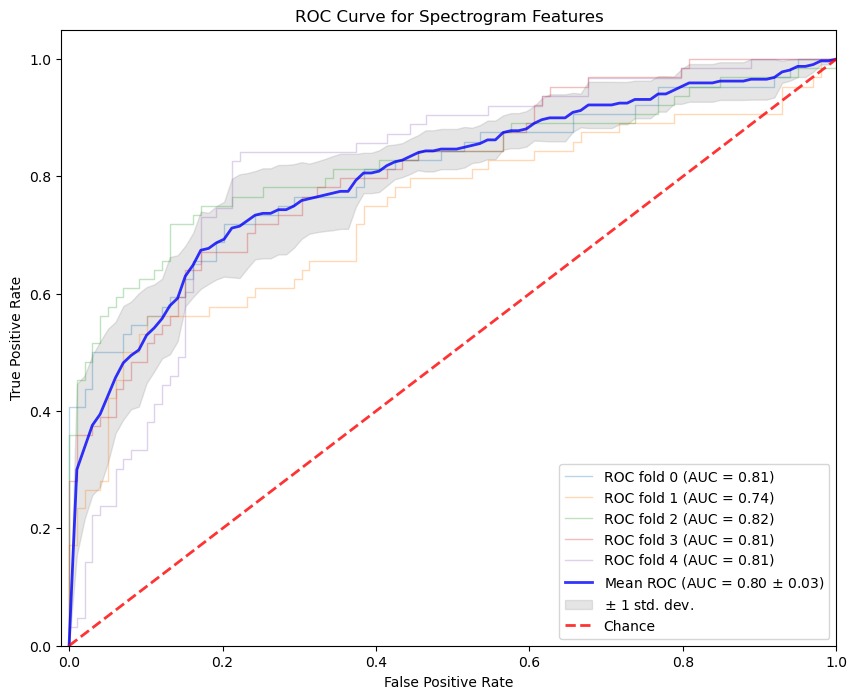

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

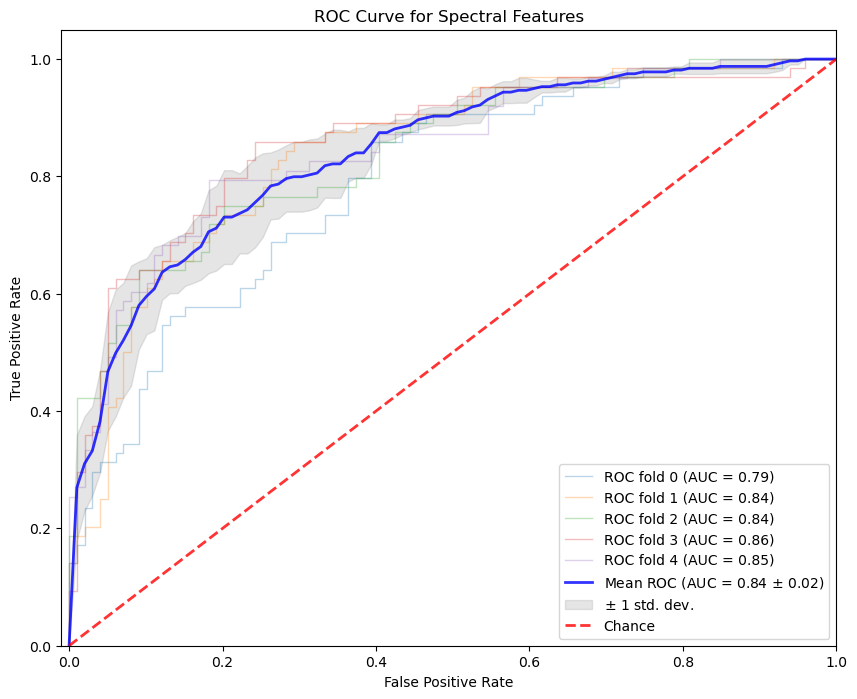

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

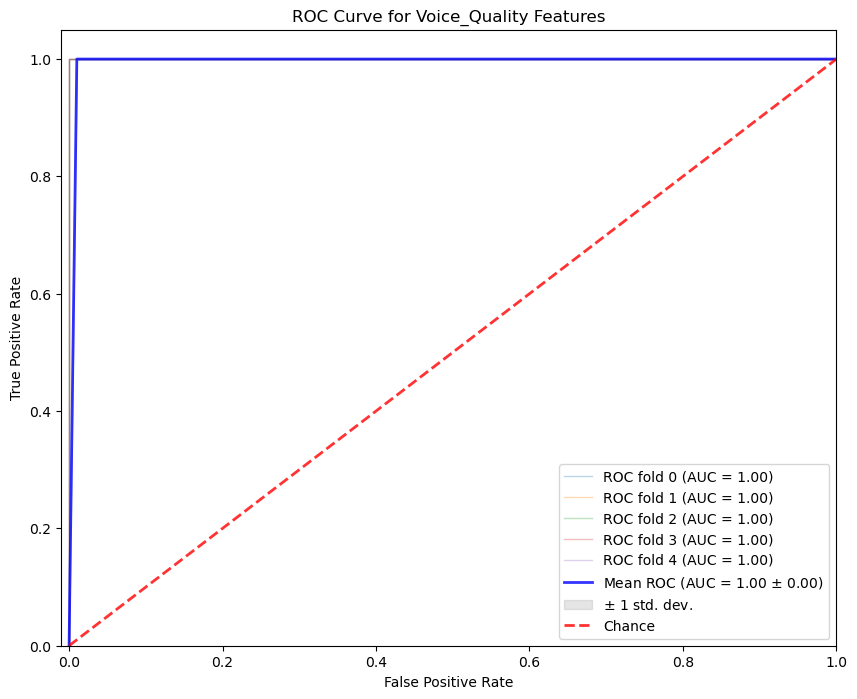

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

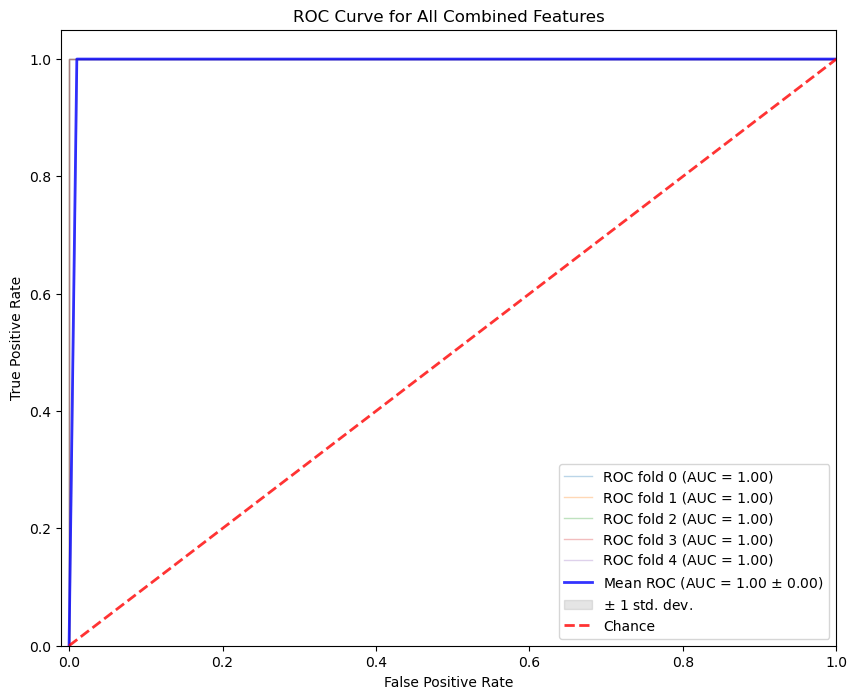

In [10]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy import interp

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Define the labels
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'base_estimator__max_depth': randint(1, 10)  # Assuming base estimator is a decision tree
}

# Store results for comparison
results = []

# Function to plot the ROC curve with standard deviation
def plot_roc_curve_with_std(clf, X, y, title):
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(10, 8))

    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        y_pred_proba = clf.predict_proba(X.iloc[test])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y.iloc[test], y_pred_proba)
        aucs.append(auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )

    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the AdaBoost classifier with DecisionTree as base estimator
    base_estimator = DecisionTreeClassifier(random_state=42)
    clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
    
    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Train the model with RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    best_clf = random_search.best_estimator_

    # Plot ROC curve with standard deviation
    plot_roc_curve_with_std(best_clf, X_train, y_train, f"ROC Curve for {group_name} Features")

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set with RandomizedSearchCV
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

# Initialize AdaBoost classifier with DecisionTree as base estimator
clf_all = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# Set up RandomizedSearchCV for all features
random_search_all = RandomizedSearchCV(
    estimator=clf_all, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

# Train the model with RandomizedSearchCV
random_search_all.fit(X_train_all, y_train_all)

best_clf_all = random_search_all.best_estimator_

# Plot ROC curve with standard deviation for all combined features
plot_roc_curve_with_std(best_clf_all, X_train_all, y_train_all, "ROC Curve for All Combined Features")



In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Define the labels
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'base_estimator__max_depth': randint(1, 10)  # Assuming base estimator is a decision tree
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the AdaBoost classifier with DecisionTree as base estimator
    base_estimator = DecisionTreeClassifier(random_state=42)
    clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
    
    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Train the model with RandomizedSearchCV
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    end_test = time.time()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set with RandomizedSearchCV
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

# Initialize AdaBoost classifier with DecisionTree as base estimator
clf_all = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# Set up RandomizedSearchCV for all features
random_search_all = RandomizedSearchCV(
    estimator=clf_all, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

# Train the model with RandomizedSearchCV
start_train_all = time.time()
random_search_all.fit(X_train_all, y_train_all)
end_train_all = time.time()

best_clf_all = random_search_all.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)[:, 1]
end_test_all = time.time()

accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all)
recall_all = recall_score(y_test_all, y_pred_all)
f1_all = f1_score(y_test_all, y_pred_all)
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_adaboost_optimized.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: MFCC
Training time (seconds): 349.9615499973297
Testing time (seconds): 0.0647282600402832
Accuracy: 0.8382352941176471
Precision: 0.8309859154929577
Recall: 0.7375
F1 Score: 0.7814569536423841
ROC AUC Score: 0.9183467741935484
Matthews Correlation Coefficient (MCC): 0.6567091352010676
Log-Loss: 0.4333861110385535
Cohen's Kappa: 0.6537749434272784
Mean Absolute Error (MAE): 0.16176470588235295
Specificity: 0.9032258064516129
Confusion Matrix:
 [[112  12]
 [ 21  59]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Spectrogram
Training time (seconds): 64.06082201004028
Testing time (seconds): 0.06455492973327637
Accuracy: 0.7843137254901961
Precision: 0.7368421052631579
Recall: 0.7
F1 Score: 0.717948717948718
ROC AUC Score: 0.8240927419354838
Matthews Correlation Coefficient (MCC): 0.5439999157345385
Log-Loss: 2.1442650712851403
Cohen's Kappa: 0.5435313262815297
Mean Absolute Error (MAE): 0.21568627450980393
Specificity: 0.8387096774193549
Confusion Matrix:
 [[104  20]
 [ 24  56]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Spectral
Training time (seconds): 107.03672862052917
Testing time (seconds): 0.07857489585876465
Accuracy: 0.8137254901960784
Precision: 0.828125
Recall: 0.6625
F1 Score: 0.736111111111111
ROC AUC Score: 0.8954637096774194
Matthews Correlation Coefficient (MCC): 0.6037470899930825
Log-Loss: 0.4005510456738996
Cohen's Kappa: 0.5948996655518395
Mean Absolute Error (MAE): 0.18627450980392157
Specificity: 0.9112903225806451
Confusion Matrix:
 [[113  11]
 [ 27  53]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Voice_Quality
Training time (seconds): 10.951356649398804
Testing time (seconds): 0.004536867141723633
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 2.2204460492503136e-16
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\Tremor_tf\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: All Combined
Training time (seconds): 212.66167283058167
Testing time (seconds): 0.03696918487548828
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Log-Loss: 0.520244586721715
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Specificity: 1.0
Confusion Matrix:
 [[124   0]
 [  0  80]]
     Feature Set  Accuracy  Precision  Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.838235   0.830986  0.7375  0.781457  0.918347  0.656709   
1    Spectrogram  0.784314   0.736842  0.7000  0.717949  0.824093  0.544000   
2       Spectral  0.813725   0.828125  0.6625  0.736111  0.895464  0.603747   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   
4   All Combined  1.000000   1.000000  1.0000  1.000000  1.000000  1.000000   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  4.333861e-01       0.653775  0.161765     0.903226     349.961550   
1  2.144265

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


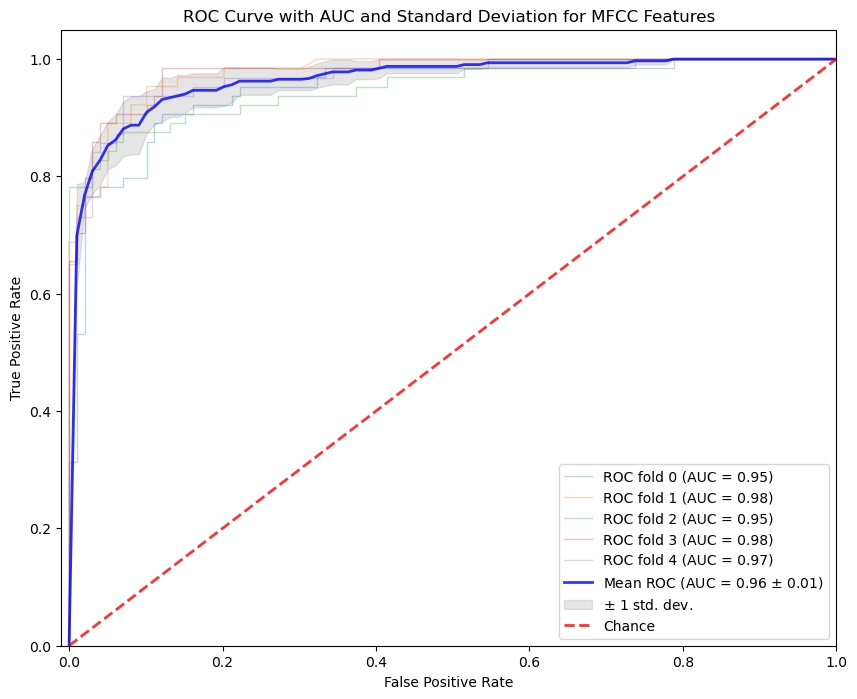

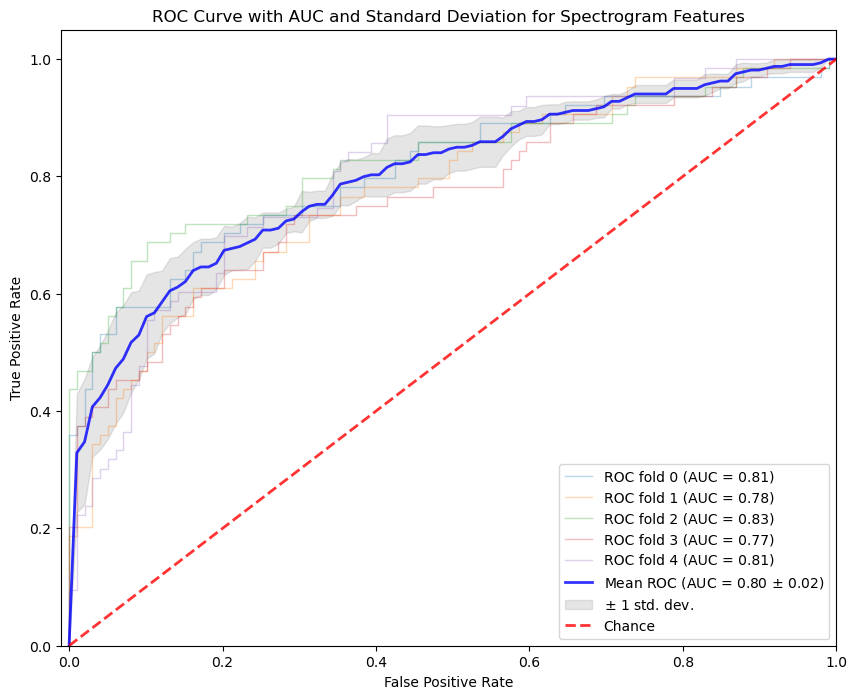

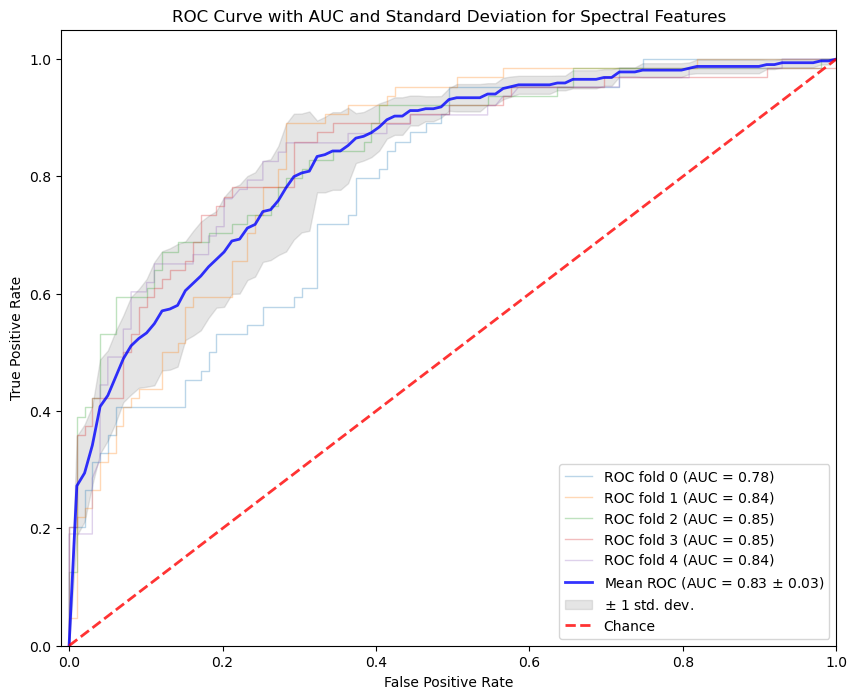

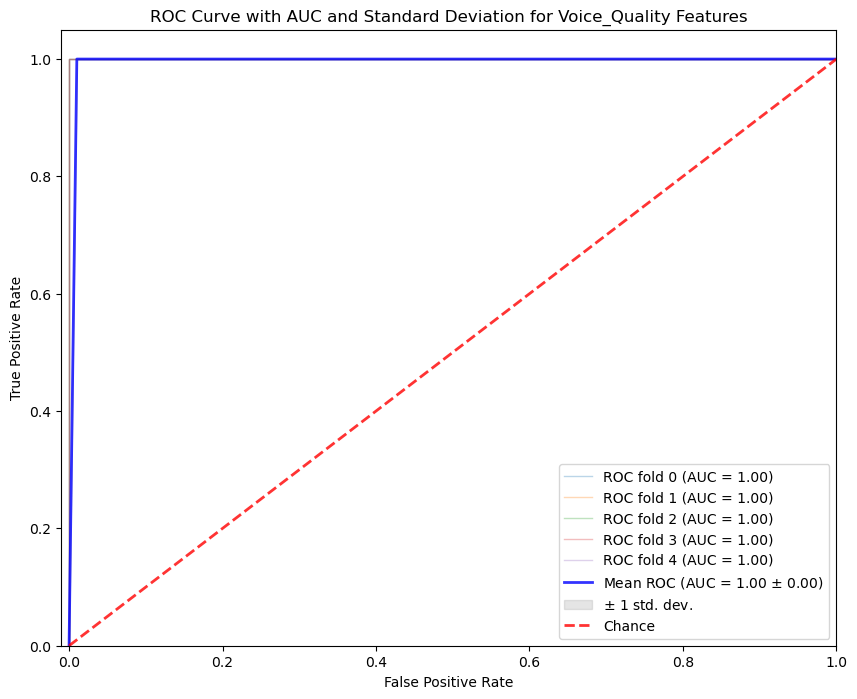


Summary of Results across Feature Sets:
     Feature Set  Accuracy  Precision  Recall        F1  ROC AUC       MCC  \
0           MFCC  0.897059   0.883117  0.8500  0.866242      1.0  0.783004   
1    Spectrogram  0.779412   0.721519  0.7125  0.716981      1.0  0.536298   
2       Spectral  0.838235   0.840580  0.7250  0.778523      1.0  0.656628   
3  Voice_Quality  1.000000   1.000000  1.0000  1.000000      1.0  1.000000   

   Log-Loss  Cohen Kappa       MAE  Specificity  Train Time (s)  Test Time (s)  
0  0.000004     0.782626  0.102941     0.883117      115.636634       0.024143  
1  0.000004     0.536270  0.220588     0.721519       53.909447       0.016330  
2  0.000004     0.652201  0.161765     0.840580       69.203037       0.041225  
3  0.000004     1.000000  0.000000     1.000000       34.862840       0.020506  


In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, confusion_matrix
import pandas as pd
import time
import numpy as np
# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# Store results for comparison
results = []

# Hyperparameter grids for RandomizedSearchCV for each base model
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

param_dist_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.3)
}

# Define the base classifiers for the StackingClassifier (RandomForest, KNN, AdaBoost)
base_learners = [
    ('rf', RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('knn', RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('adaboost', RandomizedSearchCV(AdaBoostClassifier(random_state=42), param_distributions=param_dist_adaboost, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1))
]

# Define the meta-classifier (stacking)
meta_classifier = LogisticRegression(solver='liblinear', random_state=42)
# Initialize an empty list to collect results
results = []
# Loop through each feature group (assuming `feature_groups` is already defined)
for group_name, features in feature_groups.items():
    X_group = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_group, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the StackingClassifier
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier)
    
    # Fit the stacking classifier
    start_train = time.time()
    stacking_clf.fit(X_train, y_train)
    end_train = time.time()
    
    # Start the timer for testing
    start_test = time.time()
    y_pred = stacking_clf.predict(X_test)
    end_test = time.time()
    # ROC Curve with Standard Deviation
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        stacking_clf.fit(X_train.iloc[train], y_train.iloc[train])
        y_pred_proba_cv = stacking_clf.predict_proba(X_train.iloc[test])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test], y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test], y_pred_proba_cv)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1])
     # Collect results
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1,
        'ROC AUC': roc_auc, 'MCC': mcc, 'Log-Loss': log_loss_value, 'Cohen Kappa': cohen_kappa,
        'MAE': mae, 'Specificity': specificity,
        'Train Time (s)': end_train - start_train, 'Test Time (s)': end_test - start_test
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Print the results
print("\nSummary of Results across Feature Sets:")
print(results_df)

# Optionally, you can save the results to a CSV file for further analysis
results_df.to_csv('model_performance_results.csv', index=False)


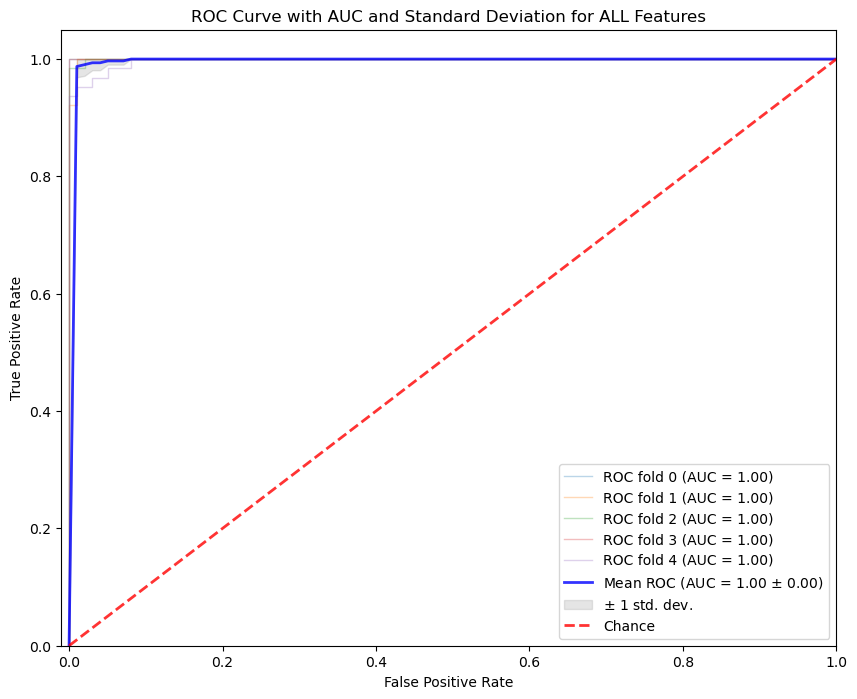


Summary of Results across Feature Sets:
  Feature Set  Accuracy  Precision  Recall        F1  ROC AUC       MCC  \
0         ALL  0.980392   0.963415  0.9875  0.975309      1.0  0.959254   

   Log-Loss  Cohen Kappa       MAE  Specificity  Train Time (s)  Test Time (s)  
0  0.000004     0.959053  0.019608     0.963415      211.583444         0.0494  


In [21]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, confusion_matrix
import pandas as pd
import time
import numpy as np
# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\EXPERIMENT\Integeral\enhanced_integral_feature_data1.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'ALL': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness','mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness','rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness','jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# Store results for comparison
results = []

# Hyperparameter grids for RandomizedSearchCV for each base model
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

param_dist_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.3)
}

# Define the base classifiers for the StackingClassifier (RandomForest, KNN, AdaBoost)
base_learners = [
    ('rf', RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('knn', RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('adaboost', RandomizedSearchCV(AdaBoostClassifier(random_state=42), param_distributions=param_dist_adaboost, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1))
]

# Define the meta-classifier (stacking)
meta_classifier = LogisticRegression(solver='liblinear', random_state=42)
# Initialize an empty list to collect results
results = []
# Loop through each feature group (assuming `feature_groups` is already defined)
for group_name, features in feature_groups.items():
    X_group = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_group, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the StackingClassifier
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier)
    
    # Fit the stacking classifier
    start_train = time.time()
    stacking_clf.fit(X_train, y_train)
    end_train = time.time()
    
    # Start the timer for testing
    start_test = time.time()
    y_pred = stacking_clf.predict(X_test)
    end_test = time.time()
    # ROC Curve with Standard Deviation
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(10, 8))
    
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        stacking_clf.fit(X_train.iloc[train], y_train.iloc[train])
        y_pred_proba_cv = stacking_clf.predict_proba(X_train.iloc[test])[:, 1]
        
        fpr, tpr, _ = roc_curve(y_train.iloc[test], y_pred_proba_cv)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        auc = roc_auc_score(y_train.iloc[test], y_pred_proba_cv)
        aucs.append(auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc:.2f})')
    
    # Plot the mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr, mean_tpr, color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )
    
    # Plot the standard deviation as a shaded area
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="r", label="Chance", lw=2, alpha=0.8)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve with AUC and Standard Deviation for {group_name} Features")
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[0,1])
     # Collect results
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1,
        'ROC AUC': roc_auc, 'MCC': mcc, 'Log-Loss': log_loss_value, 'Cohen Kappa': cohen_kappa,
        'MAE': mae, 'Specificity': specificity,
        'Train Time (s)': end_train - start_train, 'Test Time (s)': end_test - start_test
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Print the results
print("\nSummary of Results across Feature Sets:")
print(results_df)

# Optionally, you can save the results to a CSV file for further analysis
results_df.to_csv('model_performance_results.csv', index=False)


In [32]:
import os
import librosa
import numpy as np
import pandas as pd
import parselmouth
from parselmouth.praat import call
from scipy.stats import entropy, kurtosis, skew

# Define paths to your datasets
input_folders = [
    r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\ReadText\multiclass\Normal',
    r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\ReadText\multiclass\PD Severity 2',
    r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\ReadText\multiclass\PD Severity 3',
    r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\ReadText\multiclass\PD Severity 4'
]
labels = [0, 1, 2, 3]  # Assign numerical labels for each class

csv_output_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\enhanced_integral_feature_data_multiclass.csv'
segment_duration = 5  # Duration of each segment in seconds

# Function for noise reduction using spectral gating
def spectral_gating(y, sr, threshold_ratio=1.5, noise_len=0.5):
    noise_samples = int(noise_len * sr)
    noise_profile = y[:noise_samples]
    noise_spectrum = np.mean(np.abs(librosa.stft(noise_profile)), axis=1)

    stft_y = librosa.stft(y)
    stft_y_magnitude, stft_y_phase = np.abs(stft_y), np.angle(stft_y)
    spectral_threshold = noise_spectrum * threshold_ratio
    stft_y_denoised = np.where(stft_y_magnitude < spectral_threshold[:, None], 0, stft_y_magnitude)
    y_denoised = librosa.istft(stft_y_denoised * np.exp(1j * stft_y_phase))
    return y_denoised

# Function to extract features using librosa
def extract_librosa_features(y, sr):
    features = {}
    
    # MFCC and its delta features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)  # First derivative
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)  # Second derivative
    
    # Store each MFCC coefficient and its delta as separate features
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}'] = mfcc[i].mean()
        features[f'mfcc_delta_{i+1}'] = mfcc_delta[i].mean()
        features[f'mfcc_delta2_{i+1}'] = mfcc_delta2[i].mean()
    
    # Extract other features
    features['mel_spectrogram'] = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128))
    features['chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rmse'] = np.mean(librosa.feature.rms(y=y))
    features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    features['spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
    
    return features

# Extract formants and other features from the voice sample using Praat
def extract_praat_features(file_path):
    sound = parselmouth.Sound(file_path)
    point_process = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    
    features = {
        'jitter_local': call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3),
        'shimmer_local': call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6),
        'f0_mean': call(sound.to_pitch(), "Get mean", 0, 0, "Hertz"),
        'hnr': call(sound.to_harmonicity(), "Get mean", 0, 0)
    }
    return features

# Function to extract statistical features
def extract_statistical_features(y):
    energy = np.abs(librosa.feature.rms(y=y))
    return {
        'entropy': entropy(energy.flatten()),
        'kurtosis': kurtosis(energy.flatten()),
        'skewness': skew(energy.flatten())
    }

# Function to extract all features from a .wav file
def extract_features(file_path, label, file_name):
    y, sr = librosa.load(file_path, sr=None)
    y = spectral_gating(y, sr)  # Apply noise reduction
    segment_samples = segment_duration * sr
    num_segments = len(y) // segment_samples
    all_features = []
    
    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        y_segment = y[start:end]
        
        # Extract all features
        librosa_features = extract_librosa_features(y_segment, sr)
        praat_features = extract_praat_features(file_path)
        statistical_features = extract_statistical_features(y_segment)
        
        # Combine all features into a single dictionary
        segment_features = {**librosa_features, **praat_features, **statistical_features}
        segment_features['label'] = label
        segment_features['file_name'] = file_name
        segment_features['segment'] = i + 1
        all_features.append(segment_features)
        
    return all_features

# Function to process all files in a folder and assign label
def process_folder(folder_path, label):
    folder_features = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            file_features = extract_features(file_path, label, file_name)
            folder_features.extend(file_features)
    return folder_features

# Extract features from each folder
all_features = []
for folder, label in zip(input_folders, labels):
    folder_features = process_folder(folder, label)
    all_features.extend(folder_features)

# Save features to a CSV file
combined_features = pd.DataFrame(all_features)
combined_features.to_csv(csv_output_path, index=False)
print(f"Features extracted and saved to {csv_output_path}")


Features extracted and saved to F:\PhD 2021-2024\Phd-IV Year\VIII\MDVR IMAGE\enhanced_integral_feature_data_multiclass.csv


In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier
    clf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)
    end_test = time.time()
    
    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all, multi_class='ovr', average='weighted')
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_multiclass.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: MFCC
Best Parameters: {'max_depth': 44, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 283}
Training time (seconds): 61.232927083969116
Testing time (seconds): 0.036562442779541016
Accuracy: 0.8235294117647058
Precision: 0.8234529535084474
Recall: 0.8235294117647058
F1 Score: 0.7991041771104617
ROC AUC Score: 0.9517546376314536
Matthews Correlation Coefficient (MCC): 0.6799307052345878
Log-Loss: 0.5709937248454836
Cohen's Kappa: 0.636885043263288
Mean Absolute Error (MAE): 0.28921568627450983
Specificity: 1.0
Confusion Matrix:
 [[124   0   0   0]
 [ 19  24   0   0]
 [  9   1  20   0]
 [  7   0   0   0]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: Spectrogram
Best Parameters: {'max_depth': 95, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 276}
Training time (seconds): 30.3412446975708
Testing time (se

In [15]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_multiclass.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.823529   0.823453  0.823529  0.799104  0.951755  0.679931   
1    Spectrogram  0.725490   0.721241  0.725490  0.698914  0.851284  0.468122   
2       Spectral  0.759804   0.775515  0.759804  0.740142  0.874863  0.542766   
3  Voice_Quality  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000   
4   All Combined  0.980392   0.981005  0.980392  0.979660  0.999581  0.965194   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  Testing Time  
0  0.570994       0.636885  0.289216     1.000000      61.232927      0.036562  
1  0.693366       0.447555  0.397059     0.966387      30.341245      0.031805  
2  0.644754       0.514262  0.367647     0.974790      39.345612      0.046432  
3  0.054383       1.000000  0.000000     1.000000      20.760296      0.015624  
4  0.239437       0.964573  0.044118     1.000000      67.151506      0.031638

In [8]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(1, 30),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 is Manhattan distance, p=2 is Euclidean distance
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier
    clf = KNeighborsClassifier()
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)
    end_test = time.time()
    
    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = KNeighborsClassifier()
random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all, multi_class='ovr', average='weighted')
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_knn_multiclass.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: MFCC
Best Parameters: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Training time (seconds): 0.5993332862854004
Testing time (seconds): 0.3485853672027588
Accuracy: 0.8921568627450981
Precision: 0.8940793982042189
Recall: 0.8921568627450981
F1 Score: 0.8926604729372896
ROC AUC Score: 0.9058010629384365
Matthews Correlation Coefficient (MCC): 0.8094432266595113
Log-Loss: 3.887060659610673
Cohen's Kappa: 0.8092323386891099
Mean Absolute Error (MAE): 0.18627450980392157
Specificity: 0.9743589743589743
Confusion Matrix:
 [[114   3   7   0]
 [  3  38   1   1]
 [  4   1  25   0]
 [  2   0   0   5]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: Spectrogram
Best Parameters: {'n_neighbors': 14, 'p': 1, 'weights': 'distance'}
Training time (seconds): 0.4282104969024658
Testing time (seconds): 0.0
Accuracy: 0.5980392156862745
Precision: 0.4903198653198653
Recall: 0.5980392156862745
F1 Scor

In [16]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_knn_multiclass.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.892157   0.894079  0.892157  0.892660  0.905801  0.809443   
1    Spectrogram  0.598039   0.490320  0.598039  0.511079  0.645819  0.118401   
2       Spectral  0.647059   0.635633  0.647059  0.603148  0.771078  0.278395   
3  Voice_Quality  0.975490   0.975373  0.975490  0.975231  0.998161  0.956334   
4   All Combined  0.730392   0.730892  0.730392  0.728705  0.763342  0.520764   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  Testing Time  
0  3.887061       0.809232  0.186275     0.974359       0.599333      0.348585  
1  1.409277       0.092989  0.583333     0.974576       0.428210      0.000000  
2  1.418474       0.249118  0.524510     0.940678       0.457939      0.000000  
3  0.076972       0.956137  0.039216     1.000000       0.438858      0.000000  
4  9.717652       0.519753  0.357843     0.841667       0.667794      0.020068

In [8]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'max_depth': randint(5, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier
    clf = DecisionTreeClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)
    end_test = time.time()
    
    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all, multi_class='ovr', average='weighted')
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_dt_multiclass.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: MFCC
Best Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 6}
Training time (seconds): 5.213075399398804
Testing time (seconds): 0.005974531173706055
Accuracy: 0.75
Precision: 0.7624273928040494
Recall: 0.75
F1 Score: 0.7485868523919701
ROC AUC Score: 0.8399467243416568
Matthews Correlation Coefficient (MCC): 0.5594028300173861
Log-Loss: 4.663728936544357
Cohen's Kappa: 0.5585914297836232
Mean Absolute Error (MAE): 0.35294117647058826
Specificity: 0.8782608695652174
Confusion Matrix:
 [[101  14   9   0]
 [ 12  28   3   0]
 [  4   4  22   0]
 [  4   0   1   2]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Feature Set: Spectrogram
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 13}
Training time (seconds): 0.645653486251831
Testing time (seconds): 0

In [9]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_dt_multiclass.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.750000   0.762427  0.750000  0.748587  0.839947  0.559403   
1    Spectrogram  0.632353   0.615045  0.632353  0.621225  0.702408  0.314230   
2       Spectral  0.578431   0.583318  0.578431  0.578259  0.637073  0.269978   
3  Voice_Quality  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000   
4   All Combined  0.990196   0.990196  0.990196  0.990196  0.990876  0.982595   

       Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  \
0  4.663729e+00       0.558591  0.352941     0.878261       5.213075   
1  5.282242e+00       0.312019  0.563725     0.882883       0.645653   
2  1.367083e+01       0.268970  0.602941     0.773585       0.887934   
3  6.661338e-16       1.000000  0.000000     1.000000       0.537527   
4  3.533692e-01       0.982595  0.019608     1.000000       1.857528   

   Testing Time  
0      0.005975  
1      0.002132  
2      0.002151  
3      0.002991  
4      0.001994

In [12]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'hidden_layer_sizes': [(50,50,50), (100,), (100,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier
    clf = MLPClassifier(max_iter=1000, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)
    end_test = time.time()
    
    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Log-Loss:", log_loss_value)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Specificity': specificity,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = MLPClassifier(max_iter=1000, random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all, multi_class='ovr', average='weighted')
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)
specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_mlp_multiclass.csv', index=False)


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Feature Set: MFCC
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}
Training time (seconds): 38.78900146484375
Testing time (seconds): 0.0
Accuracy: 0.9117647058823529
Precision: 0.9128138292353978
Recall: 0.9117647058823529
F1 Score: 0.9074583789671601
ROC AUC Score: 0.9719069947352249
Matthews Correlation Coefficient (MCC): 0.840279245083007
Log-Loss: 0.3218118920848047
Cohen's Kappa: 0.8357193987115247
Mean Absolute Error (MAE): 0.14705882352941177
Specificity: 0.9838709677419355
Confusion Matrix:
 [[122   2   0   0]
 [  5  38   0   0]
 [  4   2  23   1]
 [  4   0   0   3]]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Feature Set: Spectrogram
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.05, 'activation': 'relu'}
Training time (seconds): 74.63763093948364
Testing time (seconds): 0.0
Accuracy: 0.6225490196078431
Precision: 0.4611474219317357
Recall: 0.6225490196078431
F1 Score: 0.5144814049155338
ROC AUC Score: 0.6591428047022784
Matthews Correlation Coefficient (MCC): 0.17538493696543056
Log-Loss: 0.8936338018605526
Cohen's Kappa: 0.11404399323181047
Mean Absolute Error (MAE): 0.5588235294117647
Specificity: 1.0
Confusion Matrix:
 [[119   0   5   0]
 [ 43   0   0   0]
 [ 22   0   8   0]
 [  5   0   2   0]]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Feature Set: Spectral
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.05, 'activation': 'tanh'}
Training time (seconds): 10.963629245758057
Testing time (seconds): 0.0050296783447265625
Accuracy: 0.6029411764705882
Precision: 0.48902218782249746
Recall: 0.6029411764705882
F1 Score: 0.49523156599677415
ROC AUC Score: 0.6502533916007949
Matthews Correlation Coefficient (MCC): 0.09421317819120853
Log-Loss: 0.9390676240418598
Cohen's Kappa: 0.06028207461328472
Mean Absolute Error (MAE): 0.6078431372549019
Specificity: 1.0
Confusion Matrix:
 [[118   0   6   0]
 [ 42   1   0   0]
 [ 24   2   4   0]
 [  6   1   0   0]]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Feature Set: Voice_Quality
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Training time (seconds): 37.055636167526245
Testing time (seconds): 0.0
Accuracy: 0.7450980392156863
Precision: 0.7793033968234254
Recall: 0.7450980392156863
F1 Score: 0.7163239498200653
ROC AUC Score: 0.797311070693343
Matthews Correlation Coefficient (MCC): 0.5358788627351174
Log-Loss: 0.677875737298757
Cohen's Kappa: 0.5079777365491651
Mean Absolute Error (MAE): 0.39215686274509803
Specificity: 0.9834710743801653
Confusion Matrix:
 [[119   2   3   0]
 [ 20  10   0  13]
 [ 12   0  18   0]
 [  0   0   2   5]]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Feature Set: All Combined
Best Parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.05, 'activation': 'tanh'}
Training time (seconds): 13.829306840896606
Testing time (seconds): 0.0
Accuracy: 0.6176470588235294
Precision: 0.5516676773802305
Recall: 0.6176470588235294
F1 Score: 0.5053478938745309
ROC AUC Score: 0.5336720042833379
Matthews Correlation Coefficient (MCC): 0.13366972370989946
Log-Loss: 1.0019014135749222
Cohen's Kappa: 0.07461471357952898
Mean Absolute Error (MAE): 0.5833333333333334
Specificity: 0.9918032786885246
Confusion Matrix:
 [[121   1   2   0]
 [ 41   2   0   0]
 [ 26   1   3   0]
 [  6   1   0   0]]
     Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.911765   0.912814  0.911765  0.907458  0.971907  0.840279   
1    Spectrogram  0.622549   0.461147  0.622549  0.514481  0.659143  0.175385   
2       Spectral  0.602941   0.489022  0.602941  0.495232  0.650253  0.09

In [18]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_mlp_multiclass.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.911765   0.912814  0.911765  0.907458  0.971907  0.840279   
1    Spectrogram  0.622549   0.461147  0.622549  0.514481  0.659143  0.175385   
2       Spectral  0.602941   0.489022  0.602941  0.495232  0.650253  0.094213   
3  Voice_Quality  0.745098   0.779303  0.745098  0.716324  0.797311  0.535879   
4   All Combined  0.617647   0.551668  0.617647  0.505348  0.533672  0.133670   

   Log-Loss  Cohen's Kappa       MAE  Specificity  Training Time  Testing Time  
0  0.321812       0.835719  0.147059     0.983871      38.789001       0.00000  
1  0.893634       0.114044  0.558824     1.000000      74.637631       0.00000  
2  0.939068       0.060282  0.607843     1.000000      10.963629       0.00503  
3  0.677876       0.507978  0.392157     0.983471      37.055636       0.00000  
4  1.001901       0.074615  0.583333     0.991803      13.829307       0.00000

In [30]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)
data = data.drop(columns=['file_name', 'segment'])
# Ensure all features are in float32, remove any NaNs or Infs
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
data = data.astype(np.float32)

# Split the dataset into features and labels
X = data.drop(columns=['label'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(3, 6),
    'learning_rate': [0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X_group = data[features].astype(np.float32)
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_group, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the classifier
    clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)
    end_test = time.time()
    
    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    specificity_all = conf_matrix_all[0, 0] / (conf_matrix_all[0, 0] + conf_matrix_all[0, 1])
    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Log-Loss:", log_loss_value)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups for overall evaluation
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features].astype(np.float32)

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all, multi_class='ovr', average='weighted')
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)


# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Log-Loss:", log_loss_value_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Specificity:", specificity_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Specificity': specificity_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_xgb_multiclass.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Feature Set: MFCC
Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 88, 'subsample': 0.8}
Training time (seconds): 42.06674361228943
Testing time (seconds): 0.044259071350097656
Accuracy: 0.8872549019607843
Precision: 0.886119871413989
Recall: 0.8872549019607843
F1 Score: 0.8767310815867461
ROC AUC Score: 0.9690623212668859
Log-Loss: 0.3485814886104639
Matthews Correlation Coefficient (MCC): 0.795628437277054
Cohen's Kappa: 0.7830991124260355
Mean Absolute Error (MAE): 0.19607843137254902
Confusion Matrix:
 [[123   1   0   0]
 [  9  34   0   0]
 [  5   1  23   1]
 [  6   0   0   1]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Feature Set: Spectrogram
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 52, 'subsample': 0.7}
Training time (seconds): 7.997491121292114
Testing time (seconds): 0.01390838623046875
Accuracy: 0.696078431372549
Precision: 0.67507337863375
Recall: 0.696078431372549
F1 Score: 0.6707294795800253
ROC AUC Score: 0.8436987562086735
Log-Loss: 0.7125331550502672
Matthews Correlation Coefficient (MCC): 0.40998375486402117
Cohen's Kappa: 0.3945428434657732
Mean Absolute Error (MAE): 0.45098039215686275
Confusion Matrix:
 [[111   6   7   0]
 [ 25  16   1   1]
 [ 11   5  14   0]
 [  5   1   0   1]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Feature Set: Spectral
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 57, 'subsample': 0.7}
Training time (seconds): 12.958801984786987
Testing time (seconds): 0.015622854232788086
Accuracy: 0.7205882352941176
Precision: 0.7252357926800117
Recall: 0.7205882352941176
F1 Score: 0.6949676856915985
ROC AUC Score: 0.8461328308229256
Log-Loss: 0.6833986256748815
Matthews Correlation Coefficient (MCC): 0.4659798568037658
Cohen's Kappa: 0.44243586669863344
Mean Absolute Error (MAE): 0.4264705882352941
Confusion Matrix:
 [[112   3   9   0]
 [ 27  14   1   1]
 [ 11   0  19   0]
 [  4   1   0   2]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Feature Set: Voice_Quality
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 57, 'subsample': 0.7}
Training time (seconds): 5.61223578453064
Testing time (seconds): 0.0020051002502441406
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Log-Loss: 0.01720366051176728
Matthews Correlation Coefficient (MCC): 1.0
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Confusion Matrix:
 [[124   0   0   0]
 [  0  43   0   0]
 [  0   0  30   0]
 [  0   0   0   7]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1573, in __init__
    self._init(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1632, in _init
    it.reraise()
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\data.py", line 1416, in next
    input_data(**self.kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 625, in input_data
    dispatch_proxy_set_data(self.proxy, new, cat_codes)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\data.py", line 1492, in dispatch_proxy_set_data
    proxy._ref_data_from_pandas(data)  # pylint: disable=W0212
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1466, in _ref_data_from_pandas
    _check_call(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:18:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:218: Check failed: m == 1 || n == 1: 

--------------------------------------------------------------------------------
124 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1573, in __init__
    self._init(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1632, in _init
    it.reraise()
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\data.py", line 1416, in next
    input_data(**self.kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 625, in input_data
    dispatch_proxy_set_data(self.proxy, new, cat_codes)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\data.py", line 1492, in dispatch_proxy_set_data
    proxy._ref_data_from_pandas(data)  # pylint: disable=W0212
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1466, in _ref_data_from_pandas
    _check_call(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:18:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:218: Check failed: m == 1 || n == 1: 

--------------------------------------------------------------------------------
113 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1573, in __init__
    self._init(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1632, in _init
    it.reraise()
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\data.py", line 1416, in next
    input_data(**self.kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 625, in input_data
    dispatch_proxy_set_data(self.proxy, new, cat_codes)
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\data.py", line 1492, in dispatch_proxy_set_data
    proxy._ref_data_from_pandas(data)  # pylint: disable=W0212
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 1466, in _ref_data_from_pandas
    _check_call(
  File "C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:18:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:218: Check failed: m == 1 || n == 1: 


In [31]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV with AdaBoost
param_dist = {
    'base_estimator__max_depth': randint(3, 10),  # Parameters for DecisionTree as base estimator
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.2, 1.0]
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X_group = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_group, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize AdaBoost with DecisionTreeClassifier as the base estimator
    base_estimator = DecisionTreeClassifier(criterion='gini', random_state=42)
    clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
    
    # RandomizedSearchCV with AdaBoost
    random_search = RandomizedSearchCV(
        estimator=clf, param_distributions=param_dist, n_iter=50,
        scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
    )
    
    # Time and train the model with parameter optimization
    start_train = time.time()
    random_search.fit(X_train, y_train)
    end_train = time.time()
    
    # Extract the best model
    best_clf = random_search.best_estimator_
    
    # Make predictions and evaluate
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    y_pred_proba = best_clf.predict_proba(X_test)
    end_test = time.time()
    
    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Log-Loss:", log_loss_value)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'MCC': mcc,
        'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups for overall evaluation
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf_all = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini', random_state=42), random_state=42)
random_search_all = RandomizedSearchCV(
    estimator=clf_all, param_distributions=param_dist, n_iter=50,
    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1
)

start_train_all = time.time()
random_search_all.fit(X_train_all, y_train_all)
end_train_all = time.time()
best_clf_all = random_search_all.best_estimator_

# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()

# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')
roc_auc_all = roc_auc_score(y_test_all, y_pred_proba_all, multi_class='ovr', average='weighted')
log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)

# Print and store the combined metrics
print("\nFeature Set: All Combined")
print("Best Parameters:", random_search_all.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)
print("ROC AUC Score:", roc_auc_all)
print("Log-Loss:", log_loss_value_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,
    'ROC AUC': roc_auc_all,
    'MCC': mcc_all,
    'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_adaboost_multiclass.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: MFCC
Best Parameters: {'base_estimator__max_depth': 6, 'learning_rate': 0.2, 'n_estimators': 57}
Training time (seconds): 415.21768736839294
Testing time (seconds): 0.015623092651367188
Accuracy: 0.8235294117647058
Precision: 0.833169185677836
Recall: 0.8235294117647058
F1 Score: 0.8086424329234184
ROC AUC Score: 0.9106238143911664
Log-Loss: 0.835713522614098
Matthews Correlation Coefficient (MCC): 0.6706232250785215
Cohen's Kappa: 0.6545463097982032
Mean Absolute Error (MAE): 0.28921568627450983
Confusion Matrix:
 [[119   2   3   0]
 [ 14  29   0   0]
 [  9   2  19   0]
 [  5   1   0   1]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Spectrogram
Best Parameters: {'base_estimator__max_depth': 6, 'learning_rate': 1.0, 'n_estimators': 160}
Training time (seconds): 63.28653049468994
Testing time (seconds): 0.0628805160522461
Accuracy: 0.7352941176470589
Precision: 0.7368752770825262
Recall: 0.7352941176470589
F1 Score: 0.7229782979022331
ROC AUC Score: 0.8347083163955566
Log-Loss: 1.3238435288051016
Matthews Correlation Coefficient (MCC): 0.5054896997207233
Cohen's Kappa: 0.5017188348109282
Mean Absolute Error (MAE): 0.38235294117647056
Confusion Matrix:
 [[108   9   7   0]
 [ 18  24   1   0]
 [  8   5  17   0]
 [  3   3   0   1]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Spectral
Best Parameters: {'base_estimator__max_depth': 8, 'learning_rate': 0.2, 'n_estimators': 84}
Training time (seconds): 110.22025060653687
Testing time (seconds): 0.04783177375793457
Accuracy: 0.7696078431372549
Precision: 0.7881926683716965
Recall: 0.7696078431372549
F1 Score: 0.7477346999405823
ROC AUC Score: 0.8603024300281431
Log-Loss: 1.9537829155471502
Matthews Correlation Coefficient (MCC): 0.5635575300394189
Cohen's Kappa: 0.5356900726392251
Mean Absolute Error (MAE): 0.3627450980392157
Confusion Matrix:
 [[117   1   6   0]
 [ 23  20   0   0]
 [ 10   1  19   0]
 [  5   1   0   1]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: Voice_Quality
Best Parameters: {'base_estimator__max_depth': 9, 'learning_rate': 1.0, 'n_estimators': 142}
Training time (seconds): 11.149338960647583
Testing time (seconds): 0.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0
Log-Loss: 6.66133814775094e-16
Matthews Correlation Coefficient (MCC): 1.0
Cohen's Kappa: 1.0
Mean Absolute Error (MAE): 0.0
Confusion Matrix:
 [[124   0   0   0]
 [  0  43   0   0]
 [  0   0  30   0]
 [  0   0   0   7]]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\envs\fresh_env\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Feature Set: All Combined
Best Parameters: {'base_estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 107}
Training time (seconds): 160.12442445755005
Testing time (seconds): 0.03466320037841797
Accuracy: 0.9950980392156863
Precision: 0.9951372549019607
Recall: 0.9950980392156863
F1 Score: 0.9950663404698888
ROC AUC Score: 1.0
Log-Loss: 0.015199415114466798
Matthews Correlation Coefficient (MCC): 0.991313299416676
Cohen's Kappa: 0.9912626349151962
Mean Absolute Error (MAE): 0.00980392156862745
Confusion Matrix:
 [[124   0   0   0]
 [  0  43   0   0]
 [  1   0  29   0]
 [  0   0   0   7]]
     Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.823529   0.833169  0.823529  0.808642  0.910624  0.670623   
1    Spectrogram  0.735294   0.736875  0.735294  0.722978  0.834708  0.505490   
2       Spectral  0.769608   0.788193  0.769608  0.747735  0.860302  0.563558   
3  Voice_Quality  1.000000   1.000000  1.000000  1.000000  1.000000 

In [32]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_adaboost_multiclass.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision    Recall  F1 Score   ROC AUC       MCC  \
0           MFCC  0.823529   0.833169  0.823529  0.808642  0.910624  0.670623   
1    Spectrogram  0.735294   0.736875  0.735294  0.722978  0.834708  0.505490   
2       Spectral  0.769608   0.788193  0.769608  0.747735  0.860302  0.563558   
3  Voice_Quality  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000   
4   All Combined  0.995098   0.995137  0.995098  0.995066  1.000000  0.991313   

       Log-Loss  Cohen's Kappa       MAE  Training Time  Testing Time  
0  8.357135e-01       0.654546  0.289216     415.217687      0.015623  
1  1.323844e+00       0.501719  0.382353      63.286530      0.062881  
2  1.953783e+00       0.535690  0.362745     110.220251      0.047832  
3  6.661338e-16       1.000000  0.000000      11.149339      0.000000  
4  1.519942e-02       0.991263  0.009804     160.124424      0.034663

In [28]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'E:\DATASET MDVR IMG ALL\FUTURE USE\Integeral\enhanced_integral_feature_data_multiclass.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Split the dataset into features and labels
X = data.drop(columns=['label', 'file_name', 'segment'])
y = data['label']

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Parameter grid for RandomizedSearchCV with AdaBoost
param_dist = {
    'base_estimator__max_depth': randint(3, 10),  # Parameters for DecisionTree as base estimator
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.2, 1.0]
}
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}


# Hyperparameter grids for RandomizedSearchCV for each base model
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}
param_dist_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.3)
}
# Define the base classifiers for the StackingClassifier (RandomForest, KNN, AdaBoost)
base_learners = [
    ('rf', RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('knn', RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('adaboost', RandomizedSearchCV(AdaBoostClassifier(random_state=42), param_distributions=param_dist_adaboost, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1))
]

# Define the meta-classifier (stacking)
meta_classifier = LogisticRegression(solver='liblinear', random_state=42)
# Initialize an empty list to collect results
results = []
# Loop through each feature group (assuming `feature_groups` is already defined)
for group_name, features in feature_groups.items():
    X_group = data[features]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_group, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize the StackingClassifier
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier)
    
    # Fit the stacking classifier
    start_train = time.time()
    stacking_clf.fit(X_train, y_train)
    end_train = time.time()
    
    # Start the timer for testing
    start_test = time.time()
    y_pred = stacking_clf.predict(X_test)
    end_test = time.time()
    

    # Calculate performance metrics for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')

    #log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print and store the metrics
    print(f"\nFeature Set: {group_name}")
    #print("Best Parameters:", random_search.best_params_)
    print("Training time (seconds):", end_train - start_train)
    print("Testing time (seconds):", end_test - start_test)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    #print("Log-Loss:", log_loss_value)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print("Cohen's Kappa:", cohen_kappa)
    print("Mean Absolute Error (MAE):", mae)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Store the results for this feature group
    results.append({
        'Feature Set': group_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,

        'MCC': mcc,
        #'Log-Loss': log_loss_value,
        "Cohen's Kappa": cohen_kappa,
        'MAE': mae,
        'Training Time': end_train - start_train,
        'Testing Time': end_test - start_test
    })

# Combine all feature groups for overall evaluation
all_features = [feature for features in feature_groups.values() for feature in features]
X_all = data[all_features]

# Train and evaluate on the combined feature set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
clf_all = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier)

start_train_all = time.time()
clf_all.fit(X_train_all, y_train_all)
end_train_all = time.time()


# Make predictions and evaluate on combined set
start_test_all = time.time()
y_pred_all = clf_all.predict(X_test_all)
#y_pred_proba_all = best_clf_all.predict_proba(X_test_all)
end_test_all = time.time()


# Calculate metrics for combined feature set
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
recall_all = recall_score(y_test_all, y_pred_all, average='weighted', zero_division=0)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')

#log_loss_value_all = log_loss(y_test_all, y_pred_proba_all)
mcc_all = matthews_corrcoef(y_test_all, y_pred_all)
cohen_kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
mae_all = mean_absolute_error(y_test_all, y_pred_all)
conf_matrix_all = confusion_matrix(y_test_all, y_pred_all)

# Print and store the combined metrics
print("\nFeature Set: All Combined")
#print("Best Parameters:", random_search_all.best_params_)
print("Training time (seconds):", end_train_all - start_train_all)
print("Testing time (seconds):", end_test_all - start_test_all)
print("Accuracy:", accuracy_all)
print("Precision:", precision_all)
print("Recall:", recall_all)
print("F1 Score:", f1_all)

#print("Log-Loss:", log_loss_value_all)
print("Matthews Correlation Coefficient (MCC):", mcc_all)
print("Cohen's Kappa:", cohen_kappa_all)
print("Mean Absolute Error (MAE):", mae_all)
print("Confusion Matrix:\n", conf_matrix_all)

# Store the results for the combined feature set
results.append({
    'Feature Set': 'All Combined',
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1 Score': f1_all,

    'MCC': mcc_all,
   # 'Log-Loss': log_loss_value_all,
    "Cohen's Kappa": cohen_kappa_all,
    'MAE': mae_all,
    'Training Time': end_train_all - start_train_all,
    'Testing Time': end_test_all - start_test_all
})

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('feature_comparison_results_COMBNE_multiclass.csv', index=False)


Feature Set: MFCC
Training time (seconds): 186.29588794708252
Testing time (seconds): 0.04445242881774902
Accuracy: 0.9117647058823529
Precision: 0.9127450980392157
Recall: 0.9117647058823529
F1 Score: 0.910473506988097
Matthews Correlation Coefficient (MCC): 0.840532498013551
Cohen's Kappa: 0.8391730903994394
Mean Absolute Error (MAE): 0.13725490196078433
Confusion Matrix:
 [[119   3   2   0]
 [  5  38   0   0]
 [  4   2  24   0]
 [  2   0   0   5]]

Feature Set: Spectrogram
Training time (seconds): 81.69952630996704
Testing time (seconds): 0.03900003433227539
Accuracy: 0.7009803921568627
Precision: 0.6618245588833824
Recall: 0.7009803921568627
F1 Score: 0.6631484501695416
Matthews Correlation Coefficient (MCC): 0.41758358953416275
Cohen's Kappa: 0.3947176419086531
Mean Absolute Error (MAE): 0.4362745098039216
Confusion Matrix:
 [[114   3   7   0]
 [ 27  13   3   0]
 [ 10   4  16   0]
 [  5   1   1   0]]

Feature Set: Spectral
Training time (seconds): 104.54215550422668
Testing time 

In [29]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'feature_comparison_results_COMBNE_multiclass.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Accuracy  Precision    Recall  F1 Score       MCC  \
0           MFCC  0.911765   0.912745  0.911765  0.910474  0.840532   
1    Spectrogram  0.700980   0.661825  0.700980  0.663148  0.417584   
2       Spectral  0.764706   0.774587  0.764706  0.747382  0.553701   
3  Voice_Quality  1.000000   1.000000  1.000000  1.000000  1.000000   
4   All Combined  0.985294   0.985642  0.985294  0.985123  0.973897   

   Cohen's Kappa       MAE  Training Time  Testing Time  
0       0.839173  0.137255     186.295888      0.044452  
1       0.394718  0.436275      81.699526      0.039000  
2       0.532132  0.357843     104.542156      0.035768  
3       1.000000  0.000000      57.973275      0.028092  
4       0.973564  0.029412     225.450269      0.053510